# Project 7 - Event Driven Finance

In [1]:
import seaborn as sns
from sqlalchemy import create_engine
import datetime
import pandas as pd
from pygments import highlight
from pygments.lexers.sql import SqlLexer
from pygments.formatters import HtmlFormatter, LatexFormatter
from IPython import display
import functools as ft
import matplotlib.pyplot as plt
import scipy as sp
import scipy.interpolate
from __future__ import division
import numpy as np
import matplotlib.dates as mdates
from scipy.optimize import minimize
from matplotlib.finance import candlestick2_ohlc
from scipy.optimize import minimize
from datetime import date
import scipy
import scipy.interpolate
from scipy.interpolate import interp1d
%matplotlib inline
import sys
sys.path.append('../utils/')

from query import query_dataframe_f, pprint_query, nbprint_and_query
use_latex = False

In [2]:
'''
    American Option Pricer with dividends - Function call
    ABM(ft.partial(VP,K=Strike,CallPut='OptType'),StockPrice,TimeToMaturity(1/360), 
               Interest Rate, Volatility, TreeSteps, Dividends))
    Dividends are given in the format np.array([[time, dividend],....,])
'''

def BPTree(n, S, u, d, ex_div):
    # Creating a binomial tree with dividends adjustment
    r = [np.array([S])]
    for i in range(n):
        if (i in ex_div[:,0]):
            adj = ex_div[ex_div[:,0]==i][0,1]
            r.append(np.concatenate((r[-1][:1]*u-adj, r[-1]*d-adj)))
        else: r.append(np.concatenate((r[-1][:1]*u, r[-1]*d))) 
    return r

def GBM(R, P, S, T, r, v, n, ex_div):
    # Function returns the American option price
    t = float(T)/n
    T_range = np.arange(0,T+t,t)
    # Selecting dividends before option's maturity date
    curr_div = ex_div[ex_div[:,0]<=T]
    div_idx = []
    # Indexing the dividends ex date in the binomial tree
    for i in range (len(curr_div[:,0])):
        T_diff = T_range[1:]-curr_div[i,0]
        T_diff[T_diff<0]=100000
        div_idx.append(np.argmin(T_diff))
    curr_div[:,0] = np.array(div_idx)
    # Defining up/down binomial step coefficients 
    u = np.exp(v * np.sqrt(t))
    d = 1./u
    p = (np.exp(r * t) - d)/(u - d)
    # Creating the binomial tree
    ptree = BPTree(n, S, u, d, curr_div)[::-1]
    # Defining a function for discounting and P-measure in the tree
    R_ = ft.partial(R, np.exp(-r*t), p)
    # Discounting through the tree with american exercise option
    return ft.reduce(R_, map(P, ptree))[0]

def American(D, p, a, b): 
    # Selecting maximum between continuation and intrinsic option value
    return np.maximum(b, D*(a[:-1]*p + a[1:]*(1-p)))

def VP(S, K, CallPut): 
    # Intrinsic value
    if (CallPut=='C'): return np.maximum(S-K, 0)
    else: return np.maximum(K-S, 0)
    
ABM = ft.partial(GBM, American)

## Problem 3

In [3]:
# Much of the code for candlestick plotting comes from this page:
# http://matplotlib.org/examples/pylab_examples/finance_demo.html
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
def plot_candlestick(values):
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
    dayFormatter = DateFormatter('%d')      # e.g., 12
    
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)
    
    candlestick_ohlc(ax, values, width=1, colorup='g', colordown='r', alpha=0.75)
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    
    plt.grid(True)
    plt.gcf().set_size_inches(10, 6)
    
    return fig, ax

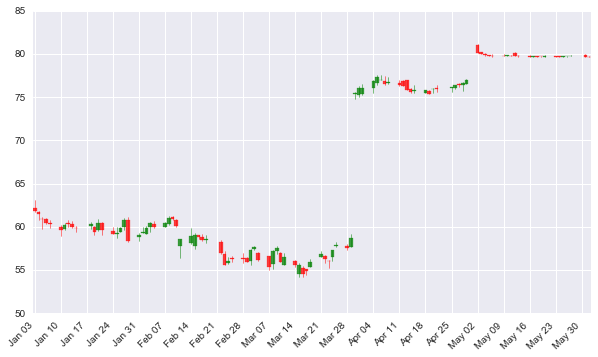

In [4]:
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import date2num
%matplotlib inline
data = query_dataframe_f('Q3-stock.sql')

# Candlestick plot of Open - High - Low- Close chart
data['date2num'] = data['Date'].apply(date2num)
plot_candlestick(data[['date2num', 'OpenPrice', 'AskHigh', 'BidLow', 'ClosePrice']].values);

There are two events that stick out to us. First, at the end of March, [Cephalon announces that they will buy ChemGenex](http://www.marketwatch.com/story/cephalon-to-buy-chemgenex-pharmaceuticals-2011-03-28) which propels the stock significantly higher. Second, at the end of April, Teva Pharmaceuticals announces that they will acquire Cephalon and the stock trades around this point for the rest of its listed time.

We will now plot the implied volatilities for the 30-, 40-, and 50-delta current-expiration options. To get the exact delta, we will interpolate between the prices surrounding a delta value to approximate an exact delta, and do our implied volatility calculations given that data.

In [24]:
# Query option data
ceph_data = query_dataframe_f('Q3-options_HI_C.sql')
# Remove options with no market
ceph_data = ceph_data[ceph_data.HasMarket == 1]

In [25]:
# Split calls and puts
ceph_data_c = ceph_data[ceph_data.CallPut == 'C']
ceph_data_p = ceph_data[ceph_data.CallPut == 'P']

In [26]:
def iv_solver(mbbo_price, stock_price, strike, expiration, rate, is_call, iv0, steps):
    if is_call:
        cp = 'C'
    else:
        cp = 'P'
    cost = lambda vol: ((mbbo_price - 
                           ABM(ft.partial(VP,K=strike,CallPut=cp),
                               stock_price,
                               expiration,
                               rate, 
                               vol, 
                               steps, 
                               np.array([0,0,0,0]).reshape(2,2)))**2)
    cons = ({'type': 'ineq',
         'fun' : lambda x: np.array(x),
         'jac': lambda x: np.array([1.0])
        })
    res = minimize(cost, iv0, constraints=cons)
    return res.x

def delta_interpolate(delta, group):
    if (len(group) < 2):
        return group
    # Given a row of data and a delta value we want to find
    # (i.e. 50 delta) get the interpolated strike/price of an option,
    # then use that to back out the implied volatility.
    
    delta_col = 'IVInterp_{}'.format(delta)
    try:
        is_call = group['CallPut'].values[0] == 'C'
    except KeyError:
        print(group['CallPut'].values)
        group[delta_col] = np.array([np.nan]*len(group))
        return group
    if is_call:
        _delta = delta
    else:
        _delta = -delta
    
    f = interp1d(group['Delta'], group[['Strike', 'MBBO', 'ImpliedVolatility']], axis=0)
    
    try:
        delta_strike, delta_price, delta_iv = f(_delta)
    except ValueError:
        #print('Dont have enough data to interpolate')
        group[delta_col] = np.array([np.nan]*len(group))
        return group
    
    steps = 100
    interp_sigma = iv_solver(
        delta_price,
        group['StockPrice'].values[0],
        delta_strike,
        group['ExpirationY'].values[0],
        group['ZeroRate'].values[0],
        is_call,
        delta_iv,
        steps
    )
    group[delta_col] = np.array([interp_sigma]*len(group))
    return group    

for delta in [.5,.4,.3]:
    ceph_data_c = ceph_data_c.groupby(['Date', 'Expiration']).apply(
        lambda group: delta_interpolate(delta, group)
    )
    ceph_data_p = ceph_data_p.groupby(['Date', 'Expiration']).apply(
        lambda group: delta_interpolate(delta, group)
    )

C:\Users\Helgi\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Helgi\Anaconda3\lib\site-packages\ipykernel\__main__.py:44: RuntimeWarning: invalid value encountered in multiply
C:\Users\Helgi\Anaconda3\lib\site-packages\ipykernel\__main__.py:44: RuntimeWarning: invalid value encountered in maximum
C:\Users\Helgi\Anaconda3\lib\site-packages\ipykernel\__main__.py:44: RuntimeWarning: invalid value encountered in add


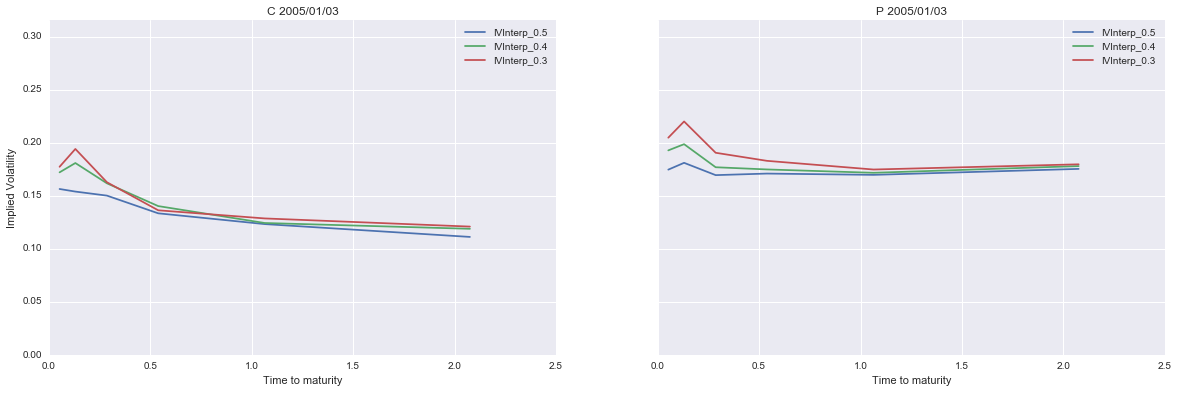

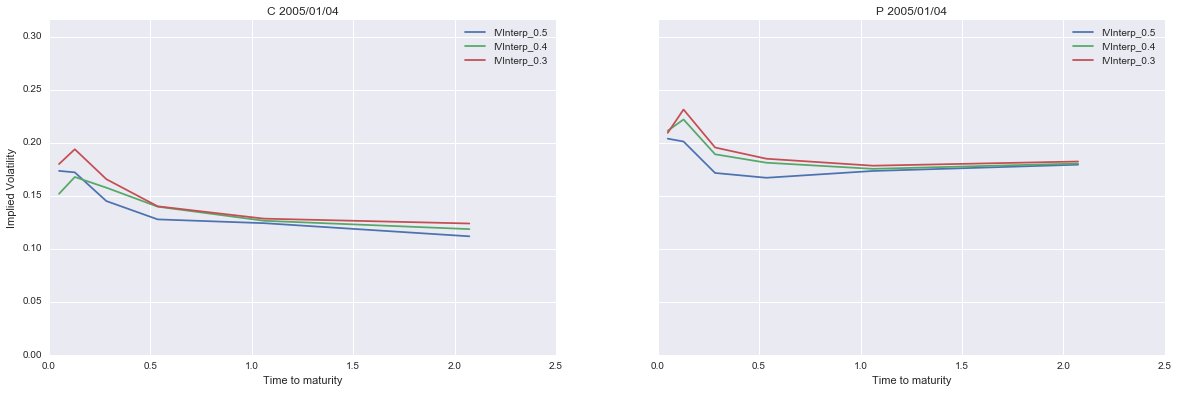

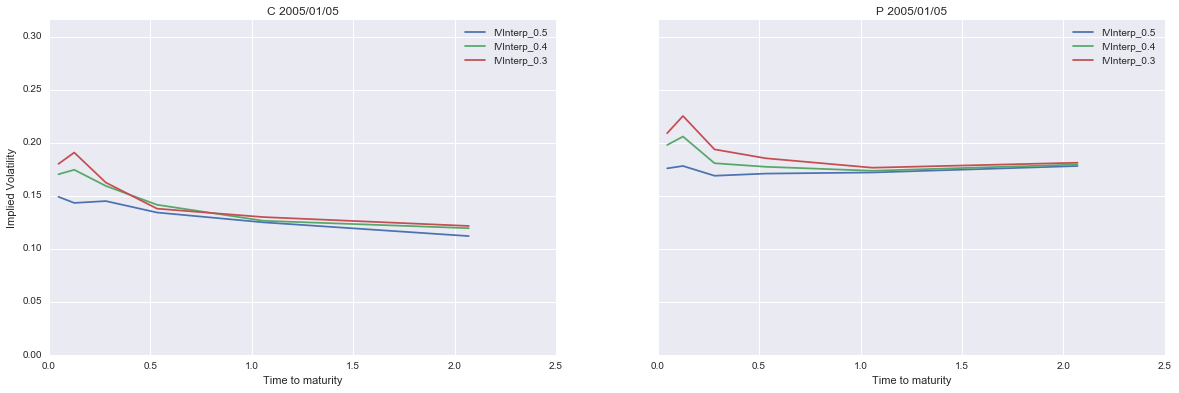

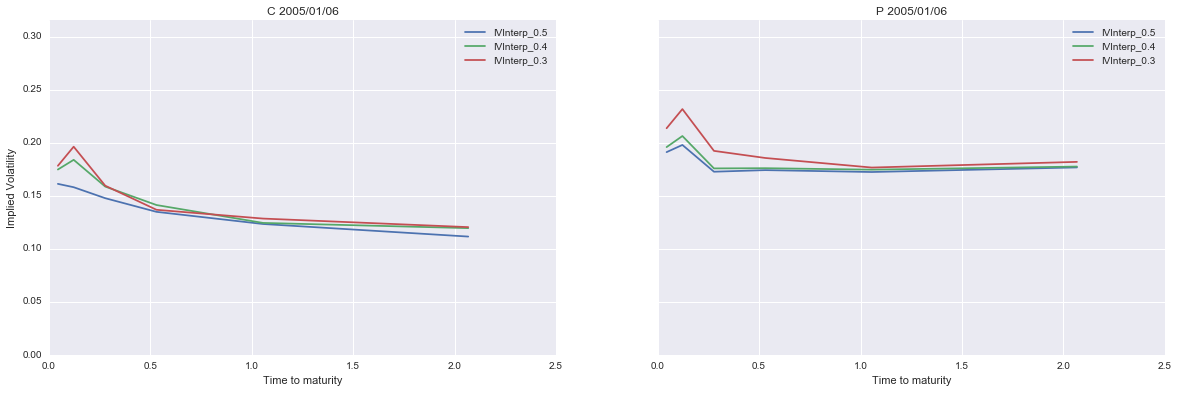

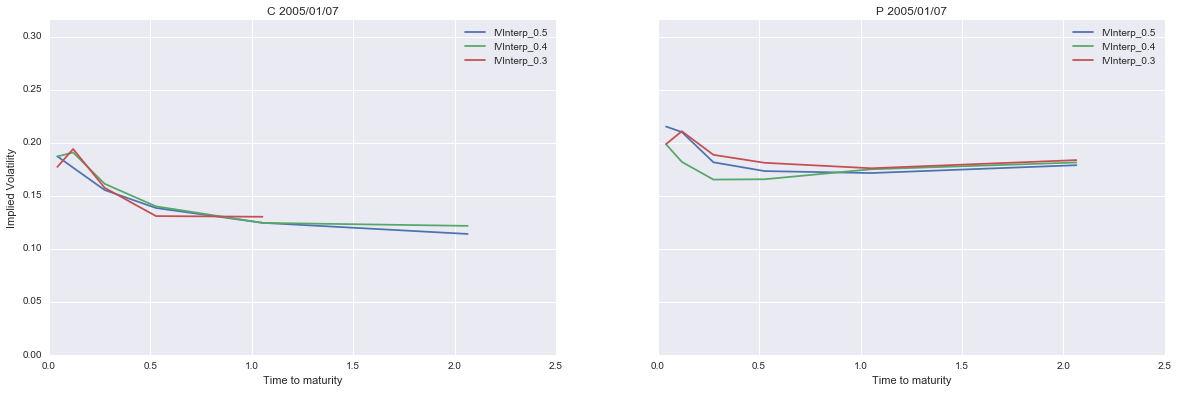

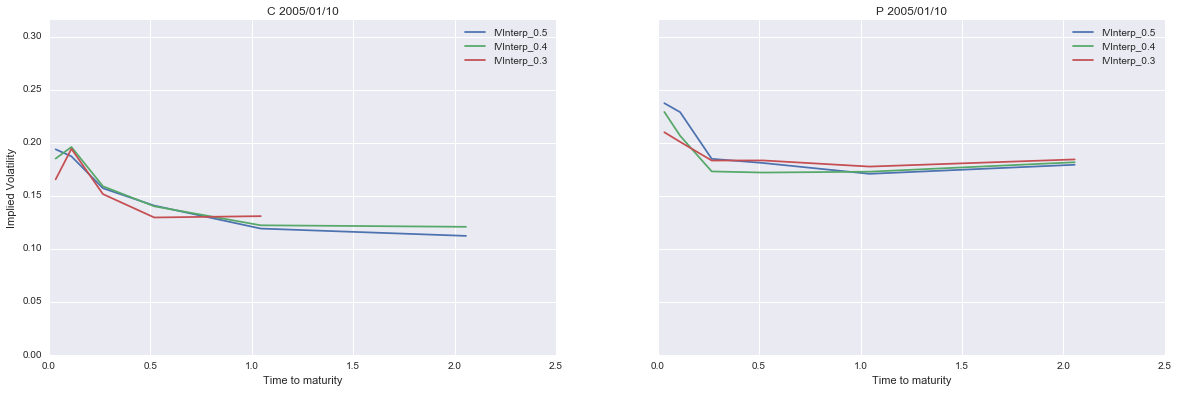

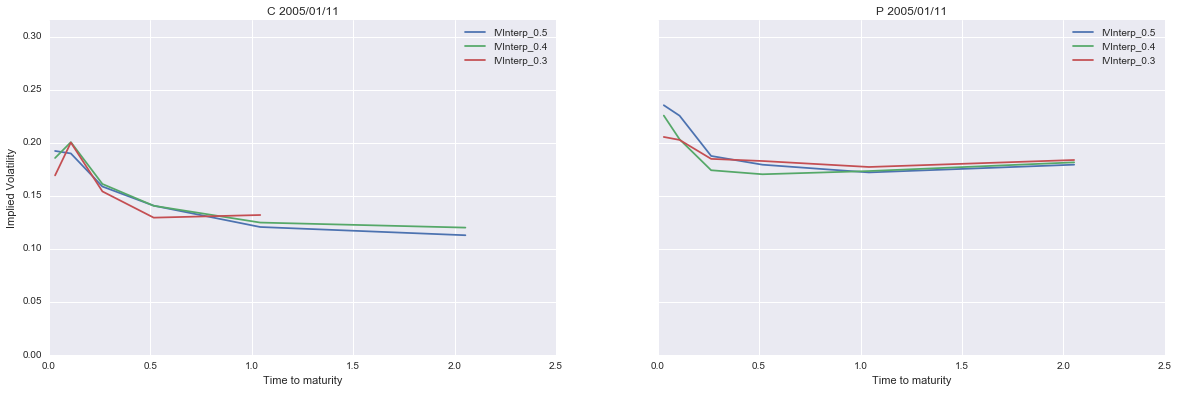

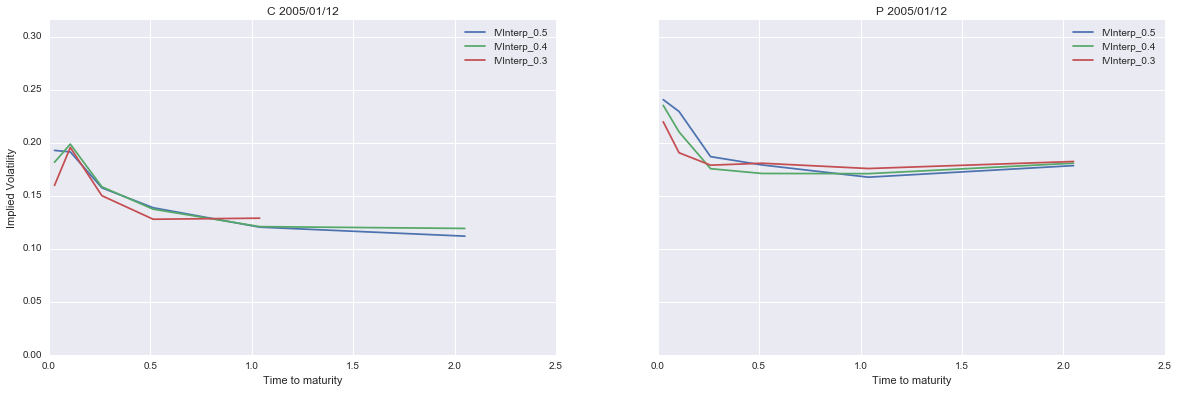

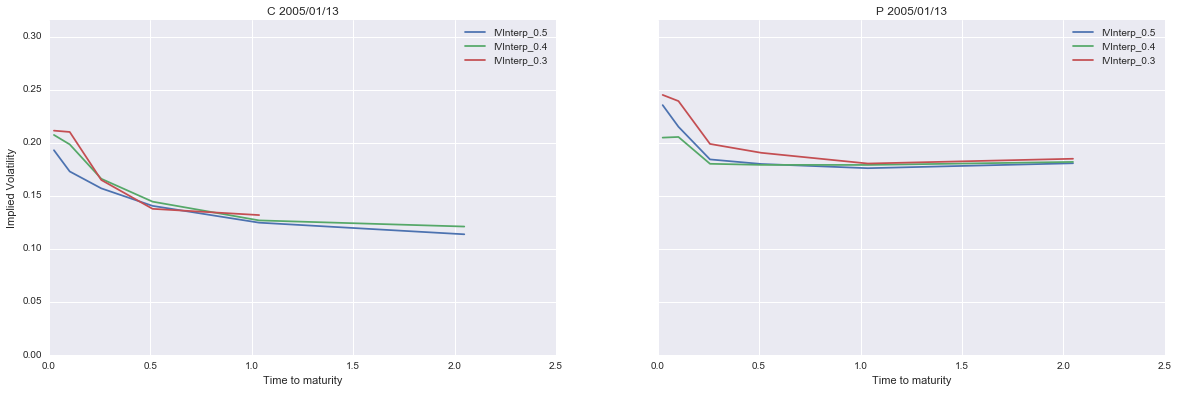

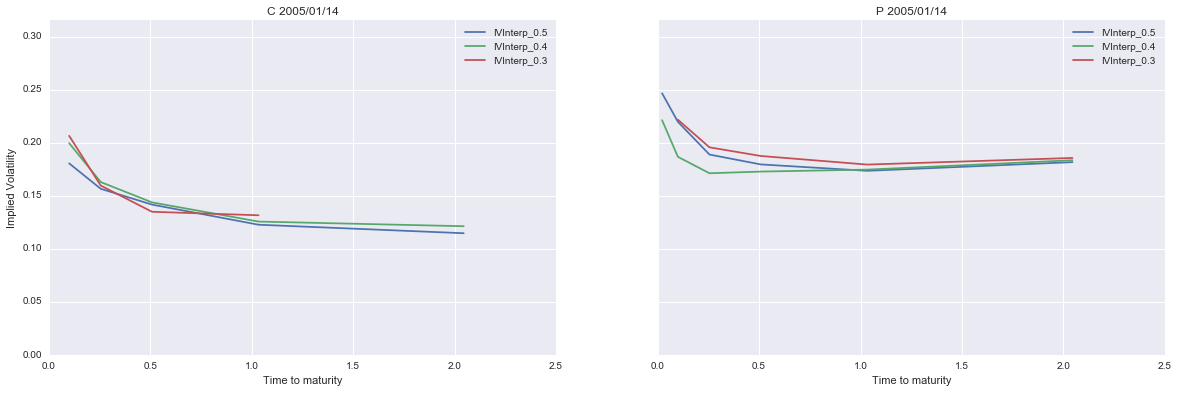

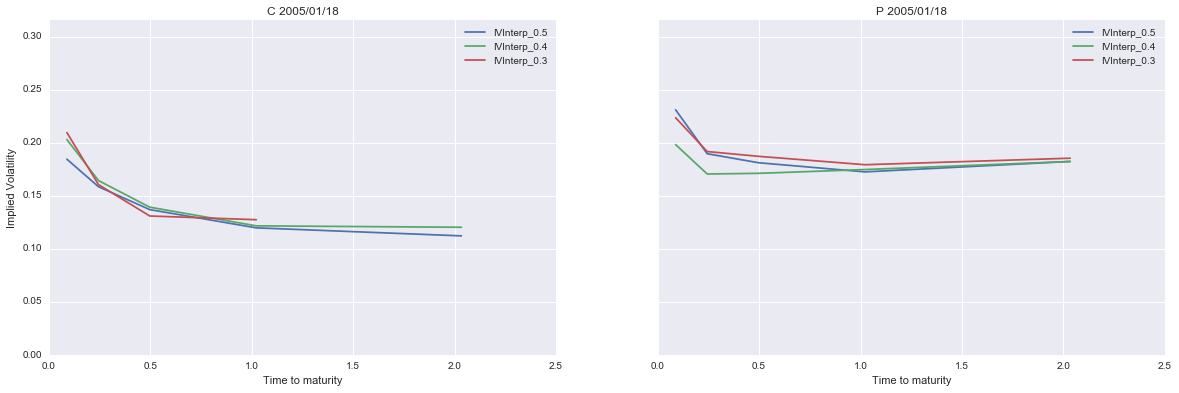

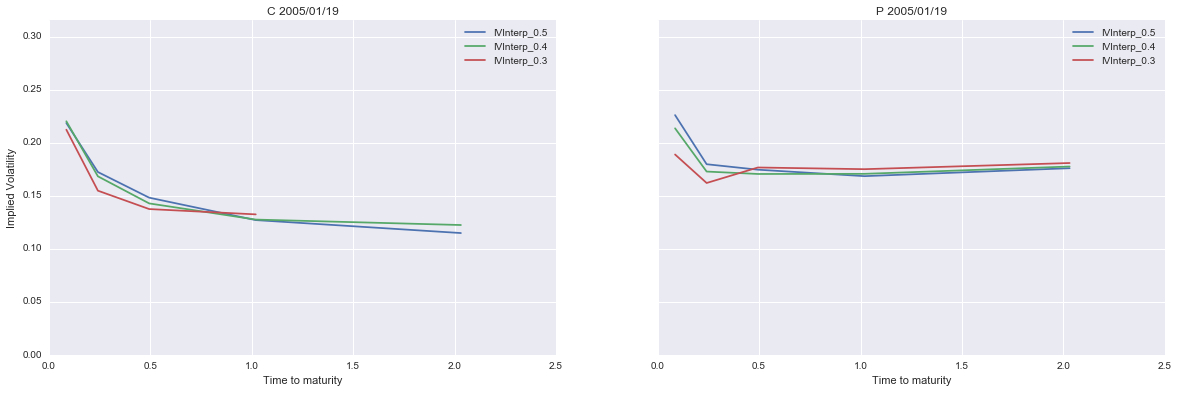

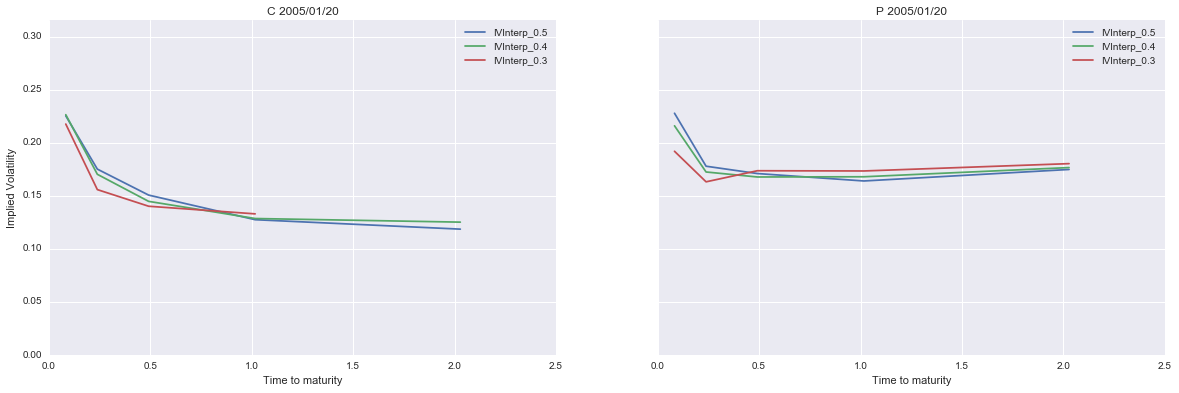

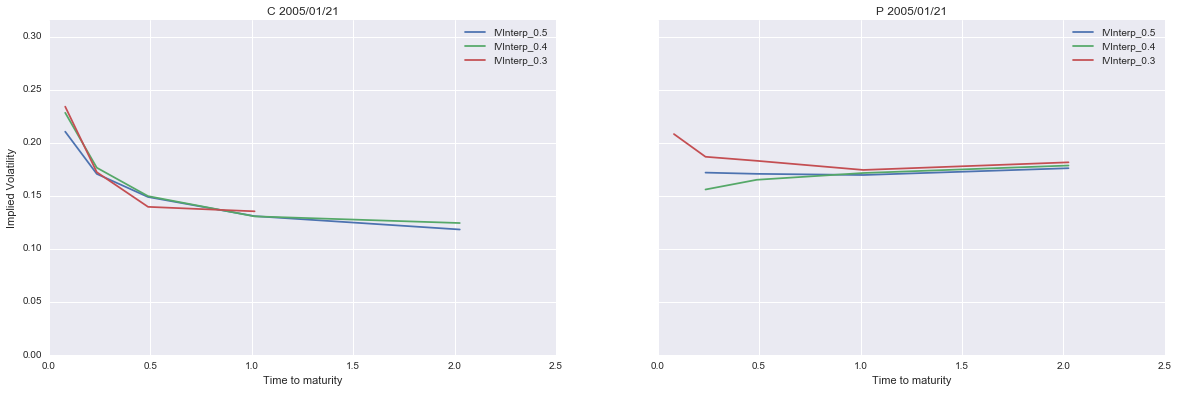

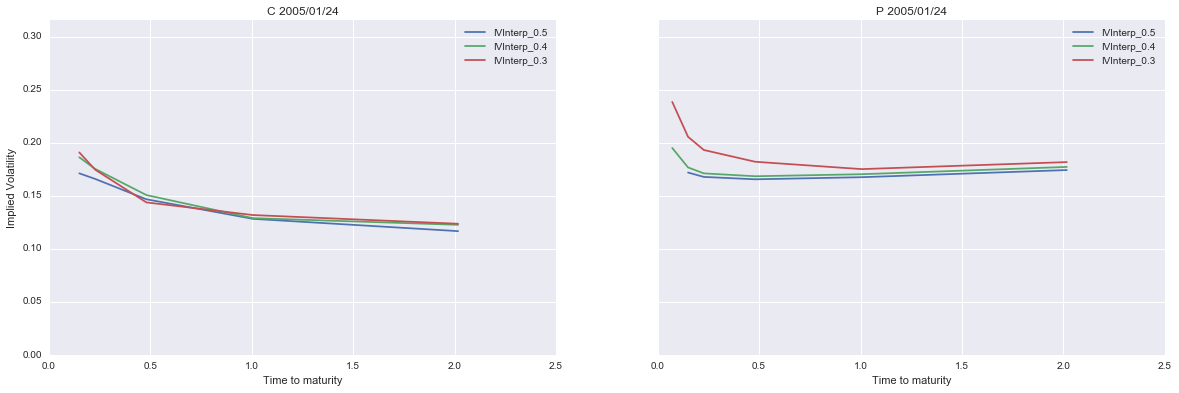

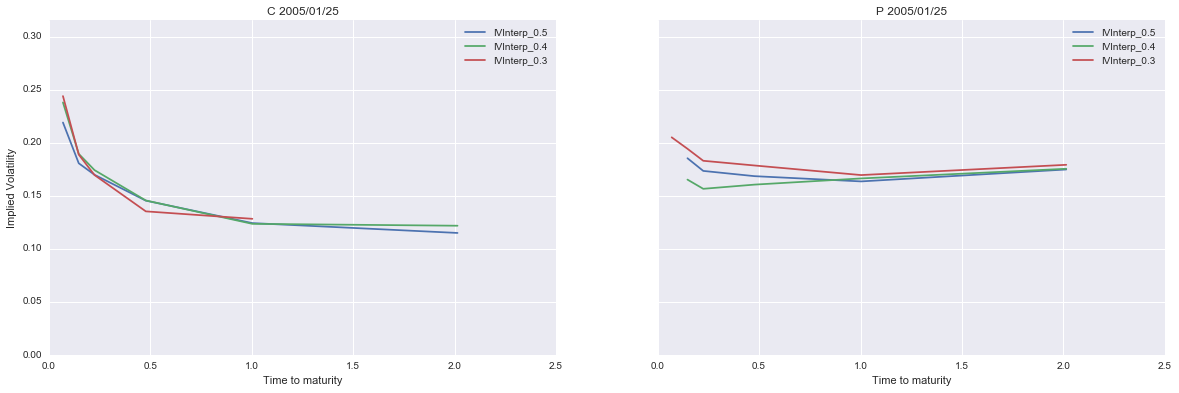

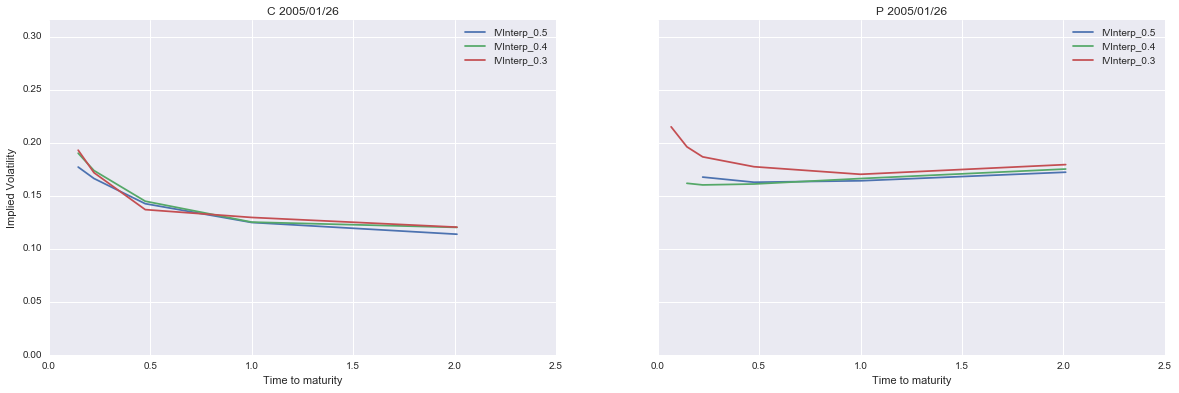

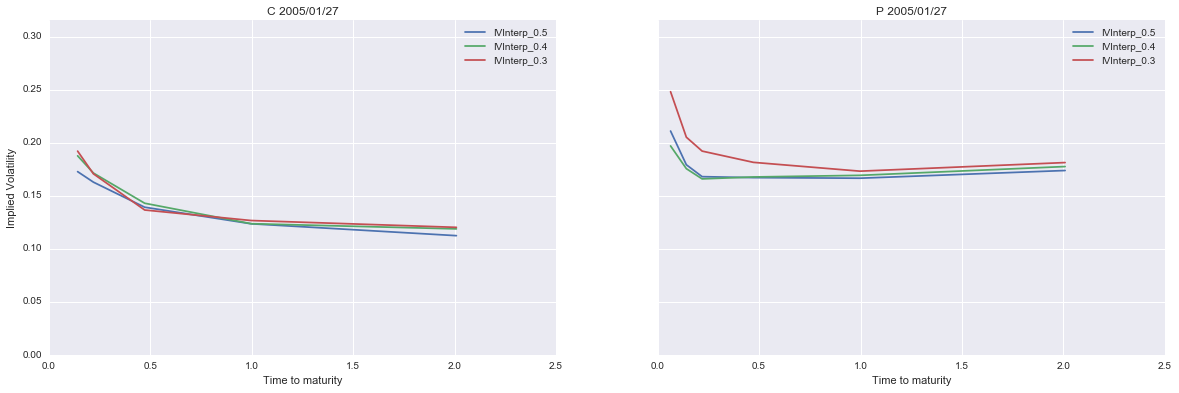

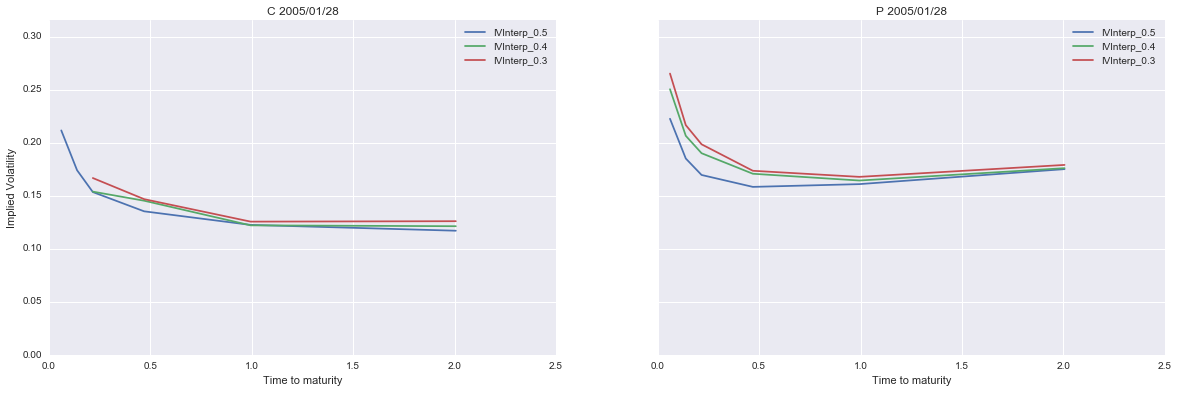

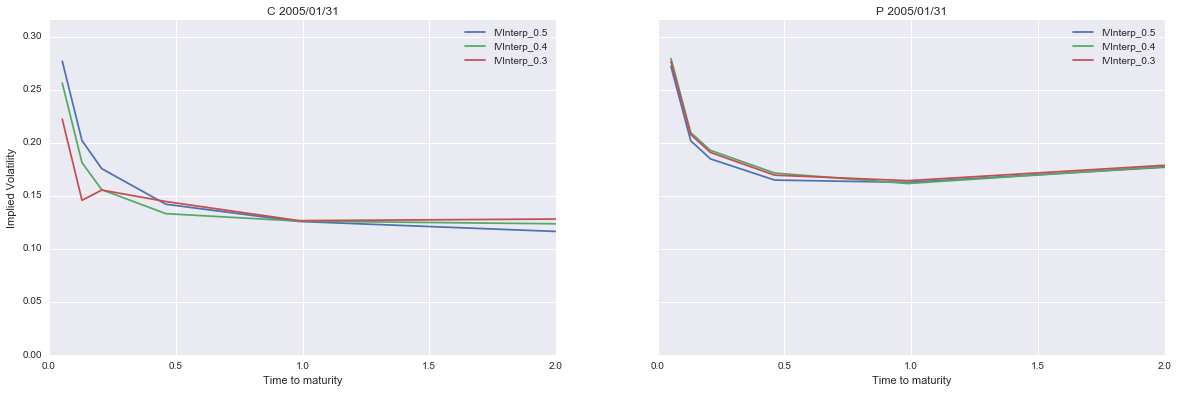

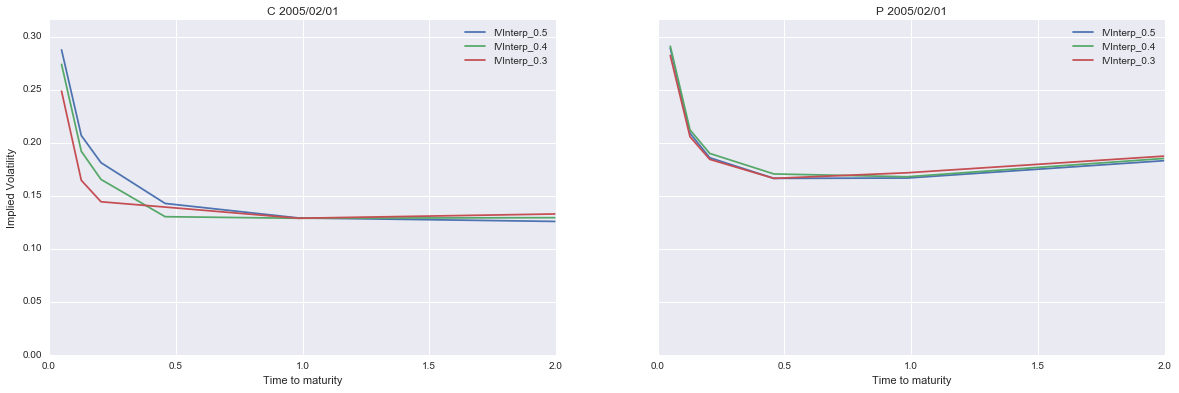

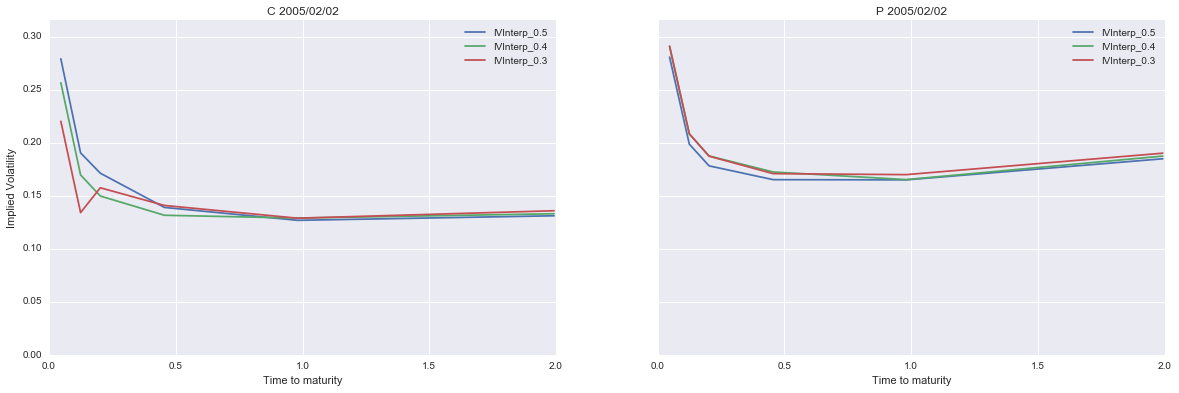

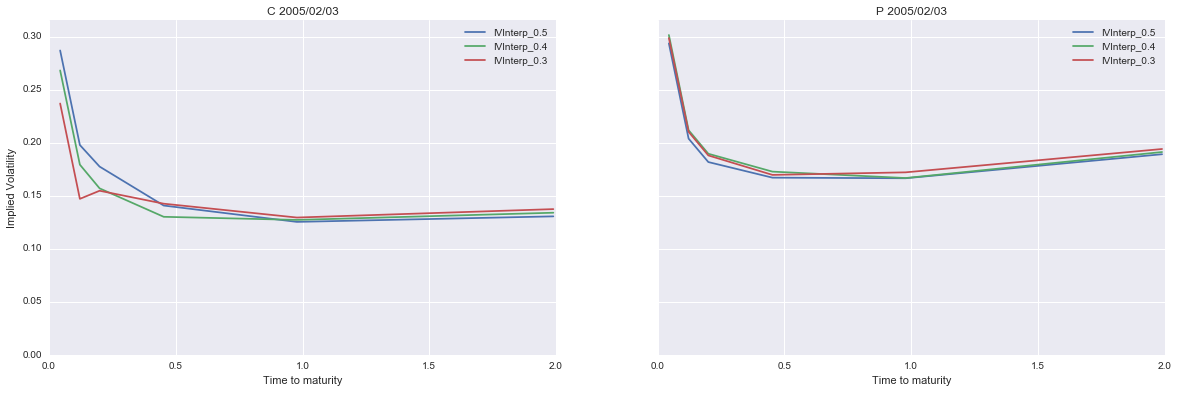

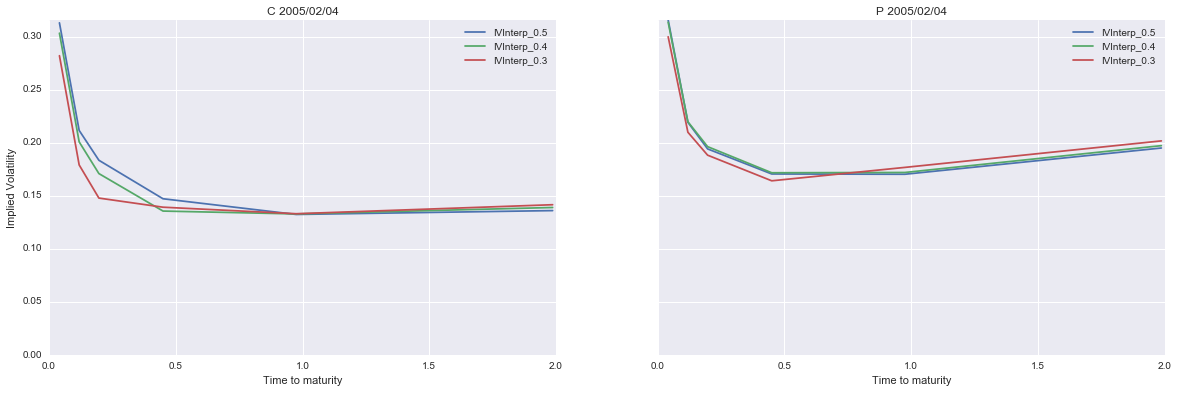

In [27]:
# IV term structures, 2011-1-1 to 2011-6-1
iv_cols=['IVInterp_0.5','IVInterp_0.4','IVInterp_0.3']
maxy = max(np.max(np.max(ceph_data_c[iv_cols].max())),np.max(np.max(ceph_data_p[iv_cols].max())))
for date in ceph_data_c.Date.unique():
    dd = pd.to_datetime(str(date)).strftime('%Y/%m/%d')
    c_ = ceph_data_c[ceph_data_c.Date==date]
    p_ = ceph_data_p[ceph_data_p.Date==date]
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.plot(c_.ExpirationY.unique(), c_.groupby(['ExpirationY'])[iv_cols].mean())
    ax2.plot(p_.ExpirationY.unique(), p_.groupby(['ExpirationY'])[iv_cols].mean())
    ax1.legend(iv_cols), ax2.legend(iv_cols)
    ax1.set_ylabel('Implied Volatility'), ax1.set_ylim([0,maxy])
    ax1.set_xlabel('Time to maturity'), ax2.set_xlabel('Time to maturity')
    ax1.set_title('C {}'.format(dd)), ax2.set_title('P {}'.format(dd))
    plt.gcf().set_size_inches(20, 6)
    plt.show()  

In [ ]:
# Total oi, calls and puts
ceph_data_c.groupby(['Date'])['OpenInterest'].sum().plot()
ceph_data_p.groupby(['Date'])['OpenInterest'].sum().plot()
plt.legend(['Call OI','Put OI'])
plt.gcf().set_size_inches(20, 6)
plt.show() 

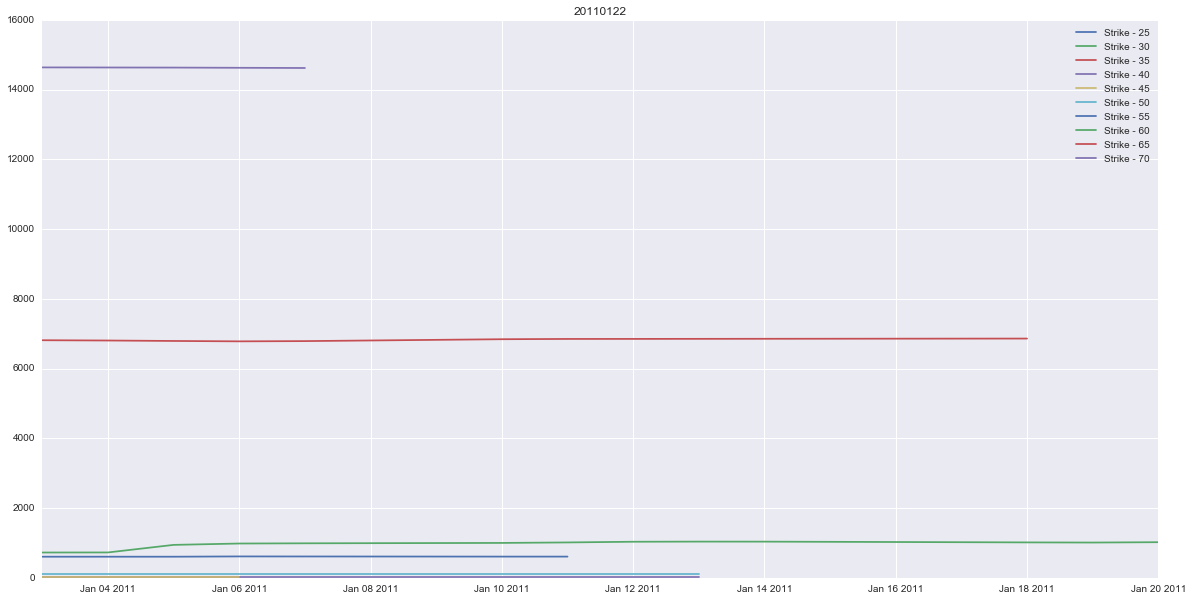

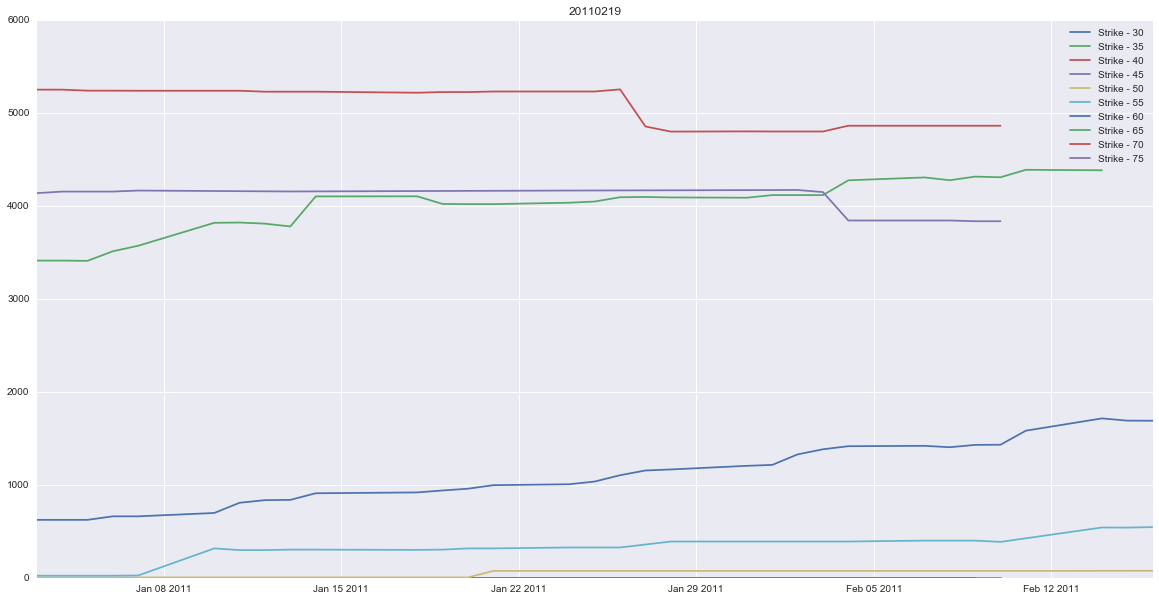

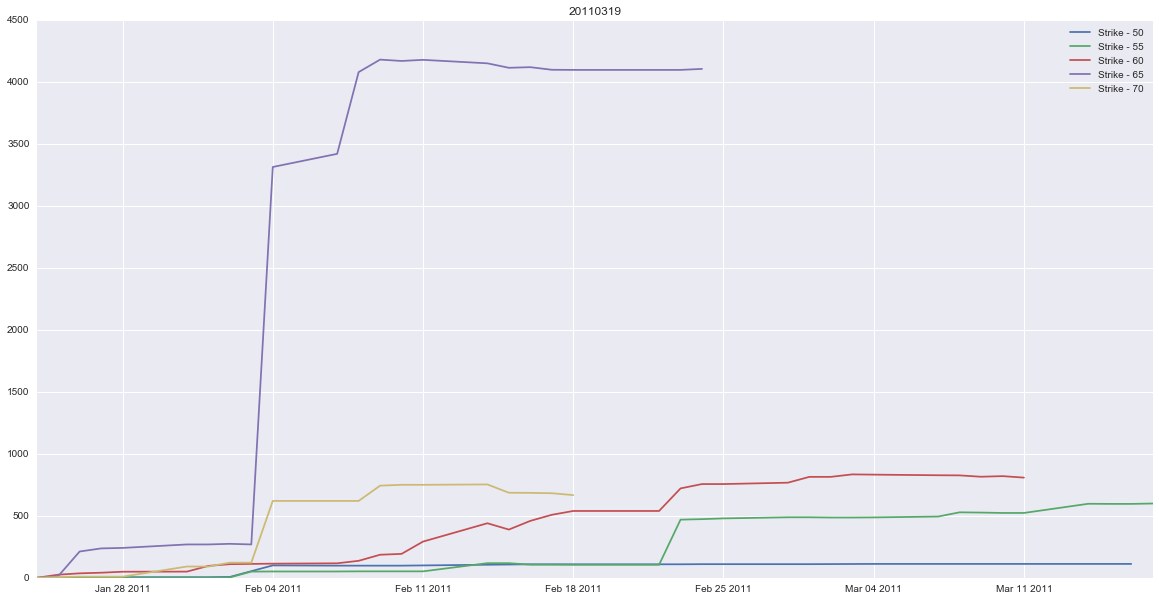

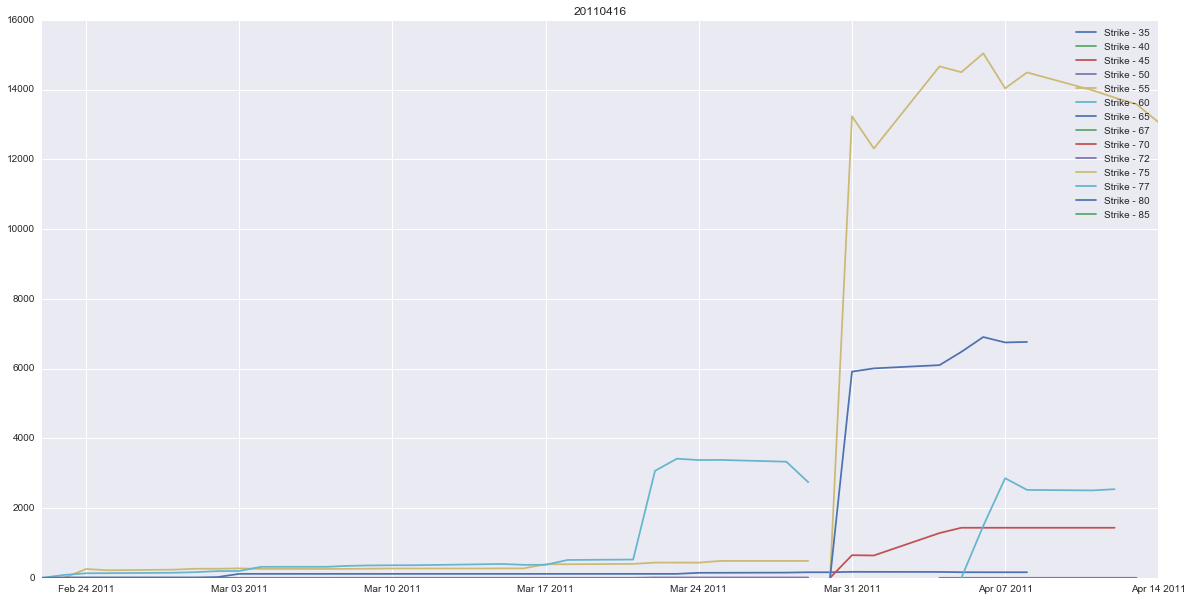

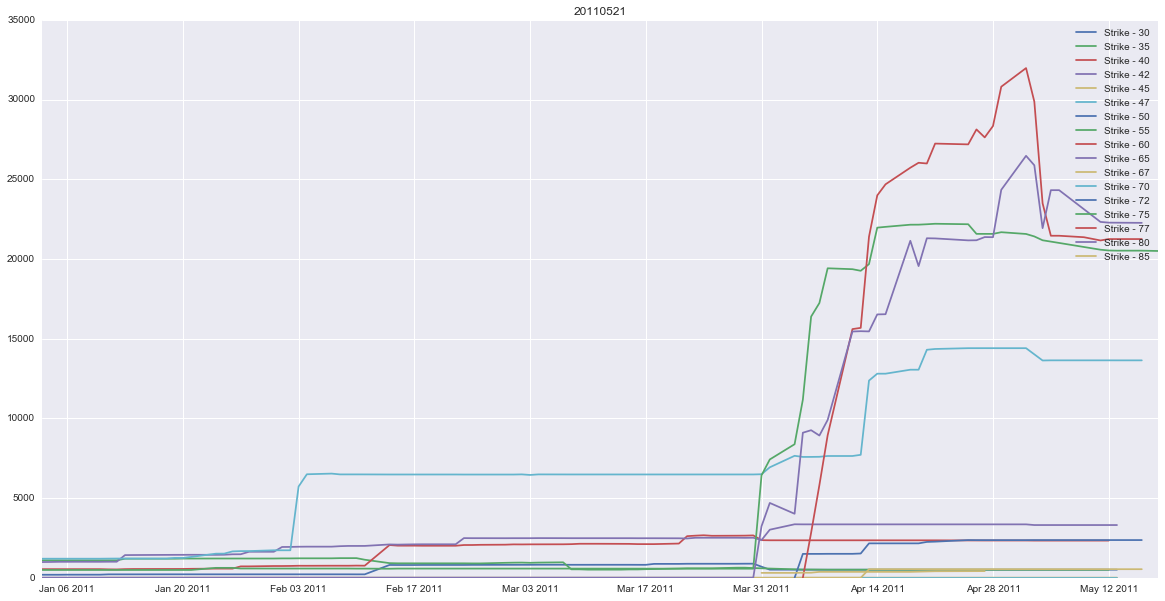

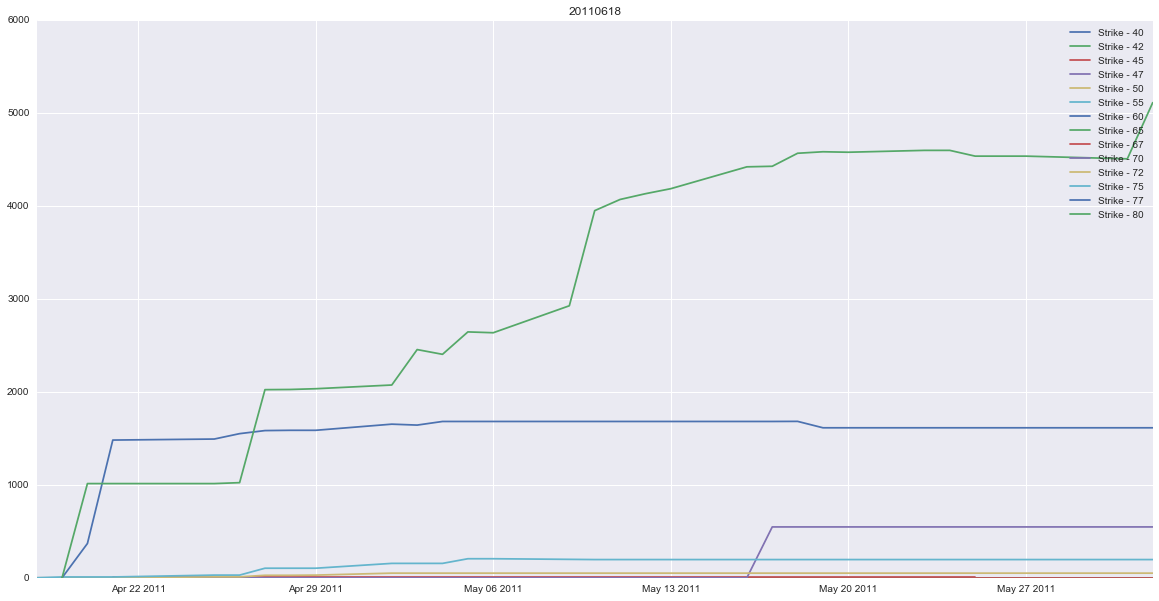

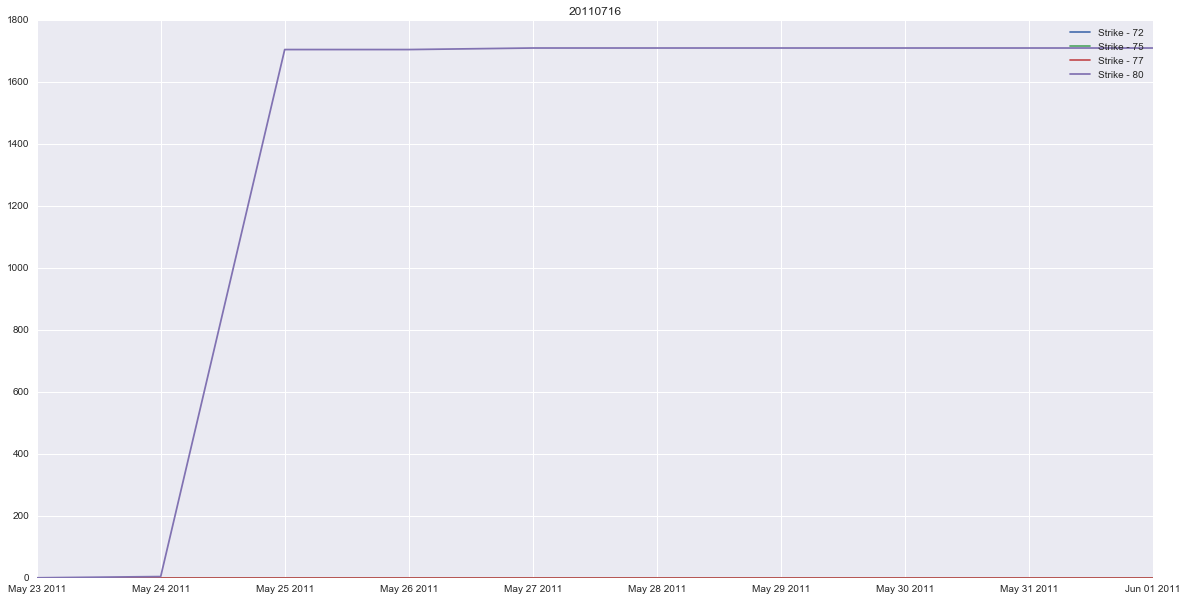

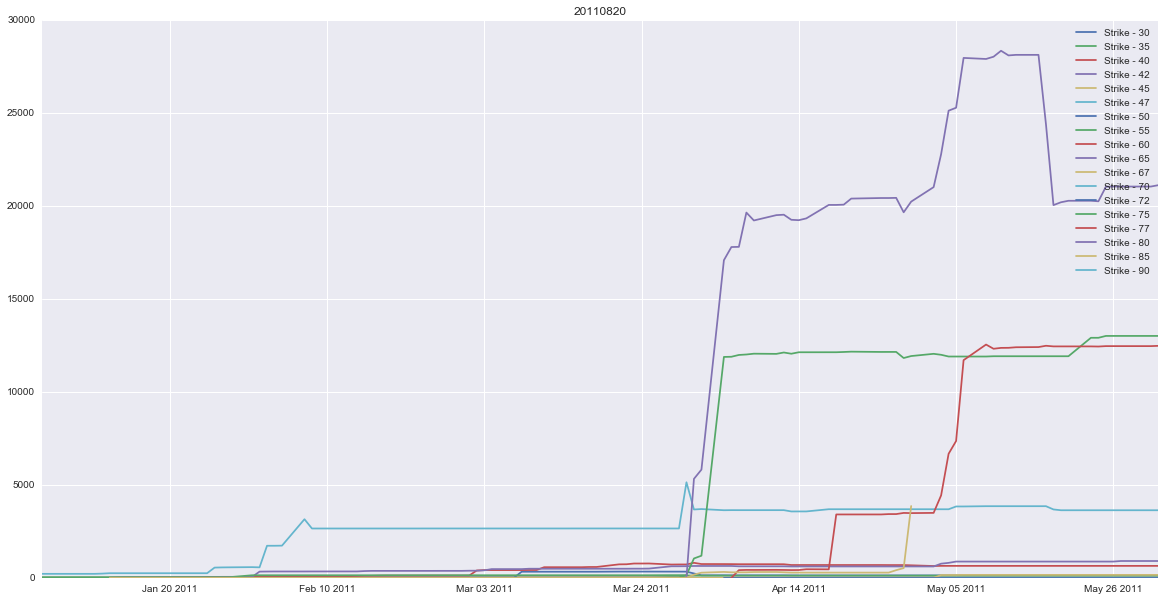

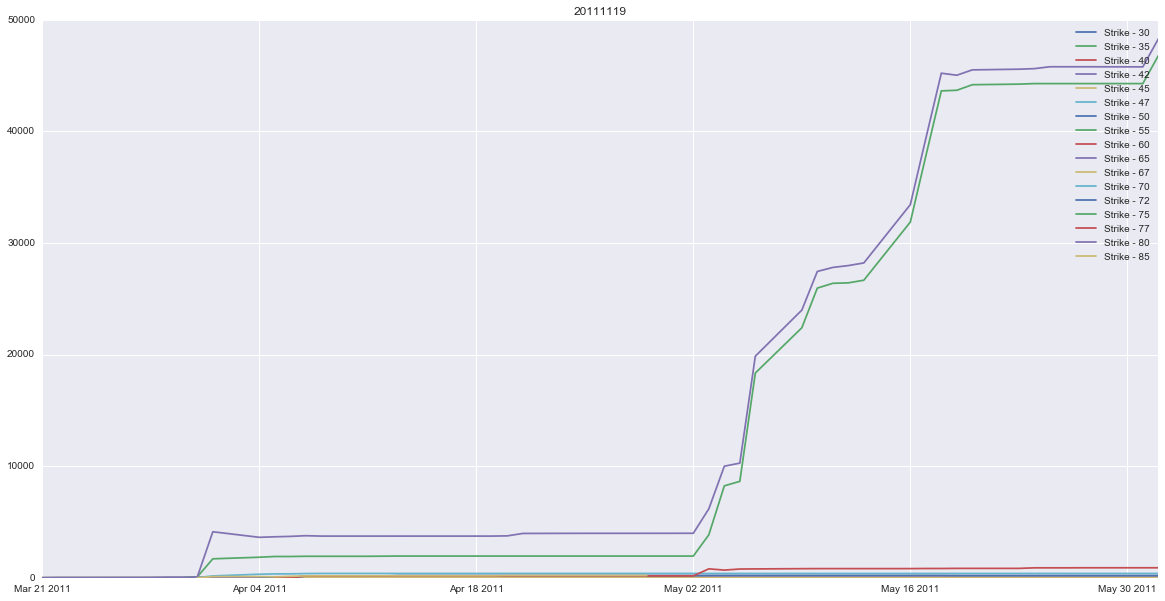

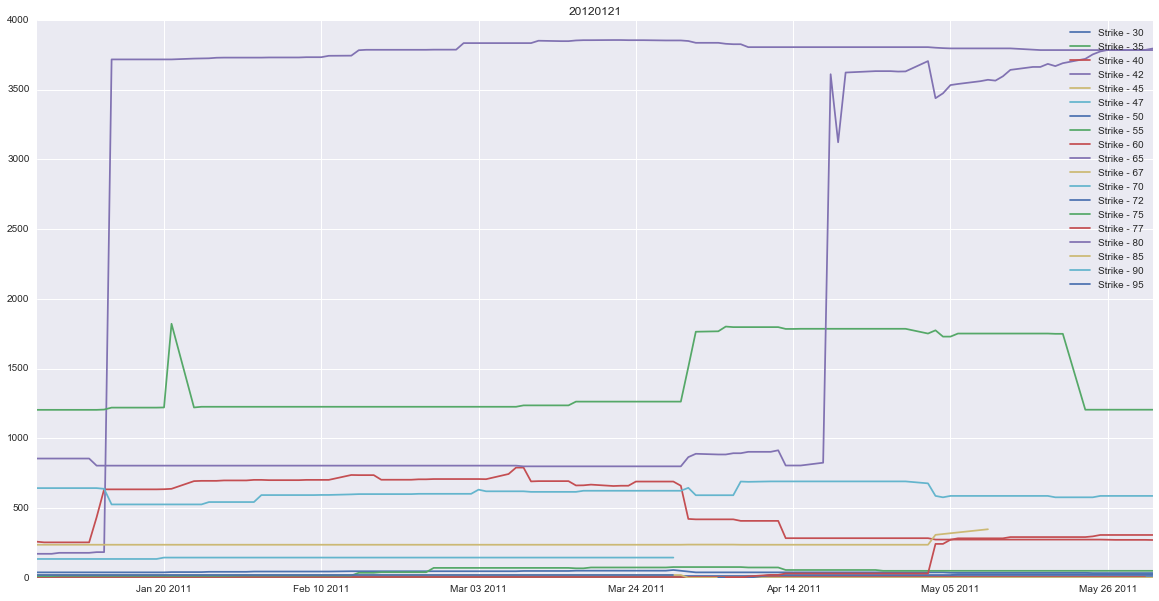

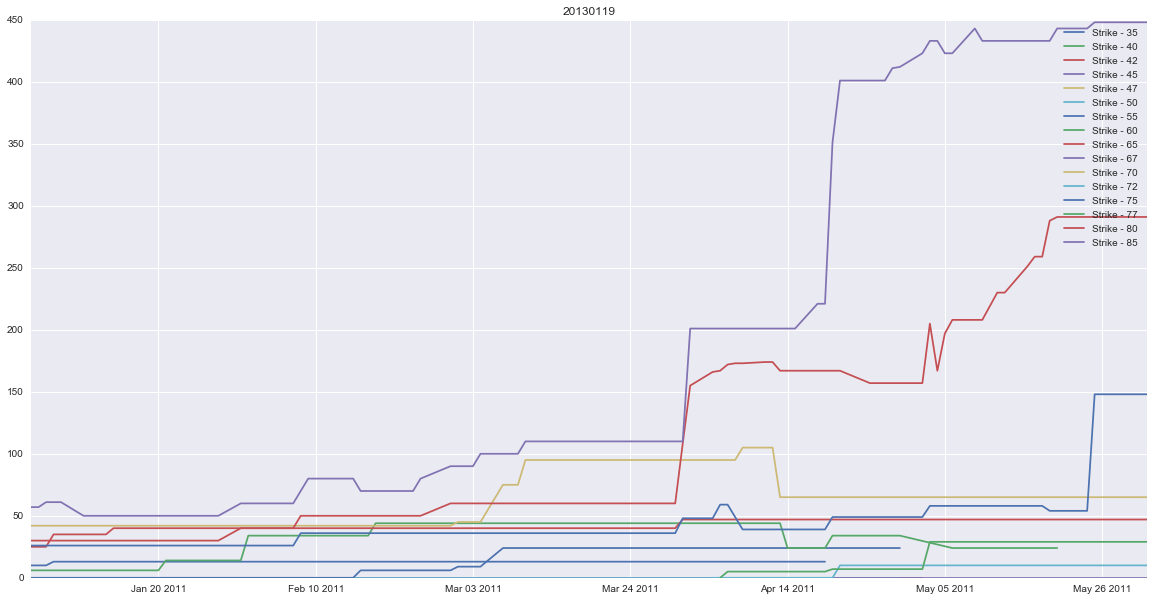

In [441]:
# Open interest by expiration, calls
for idx, row in ceph_data_c.groupby(['Expiration']):
    plt.figure()
    for jdx, row2 in row.groupby('Strike'):
        lab = 'Strike - '+str(int(jdx))
        plt.plot(row2['Date'],row2['OpenInterest'],label=lab)
    plt.title(idx.strftime('%Y%m%d'))
    plt.gcf().set_size_inches(20, 10)
    plt.legend()
    plt.show()

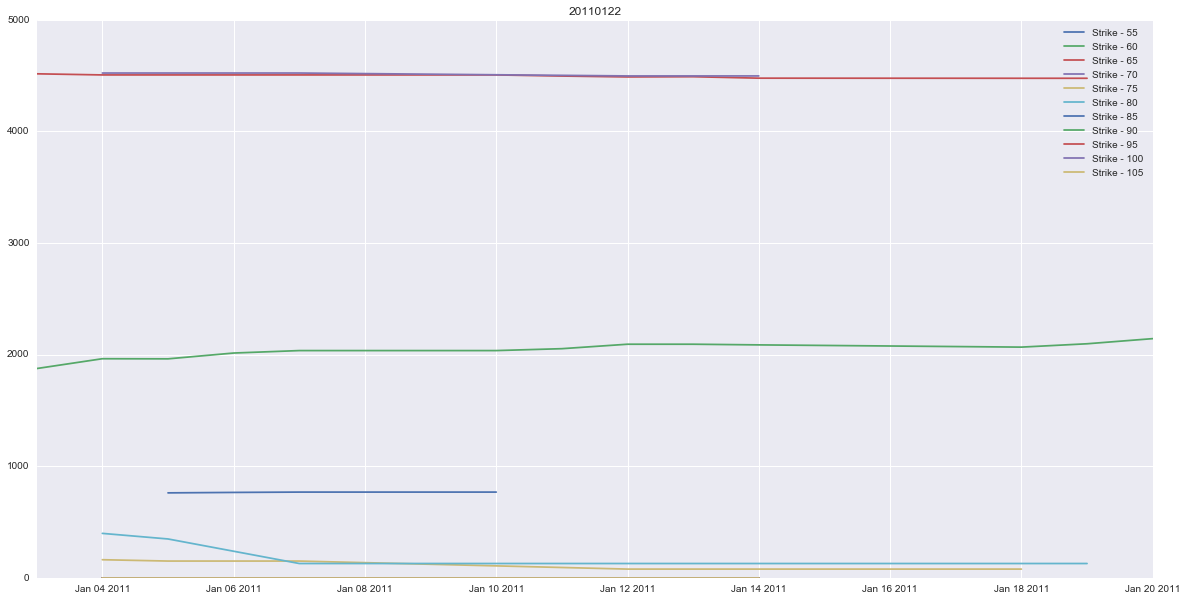

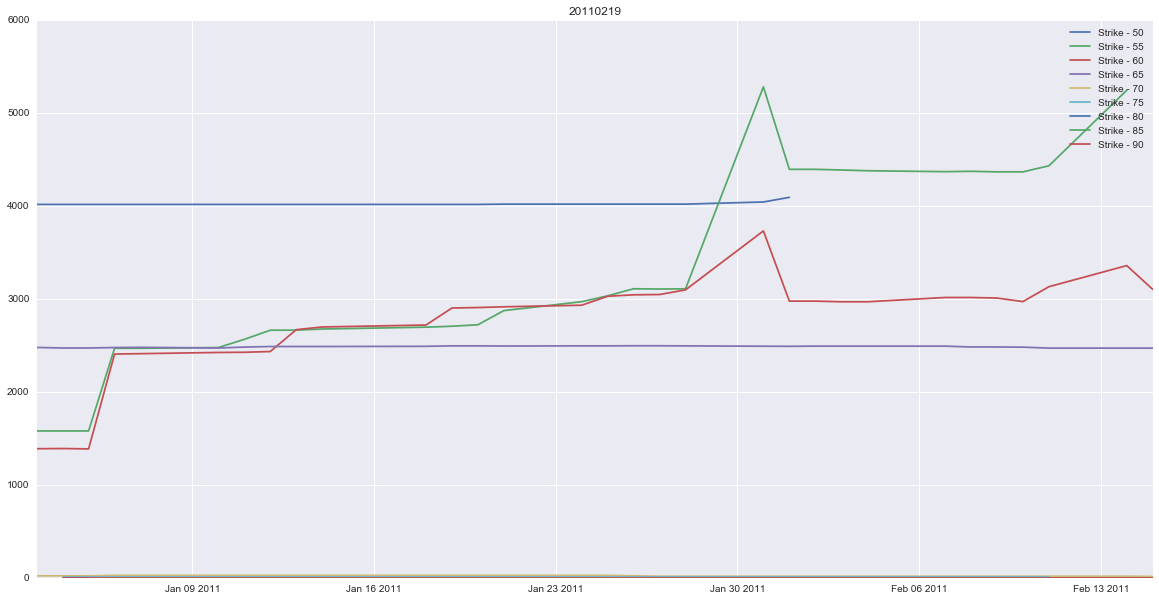

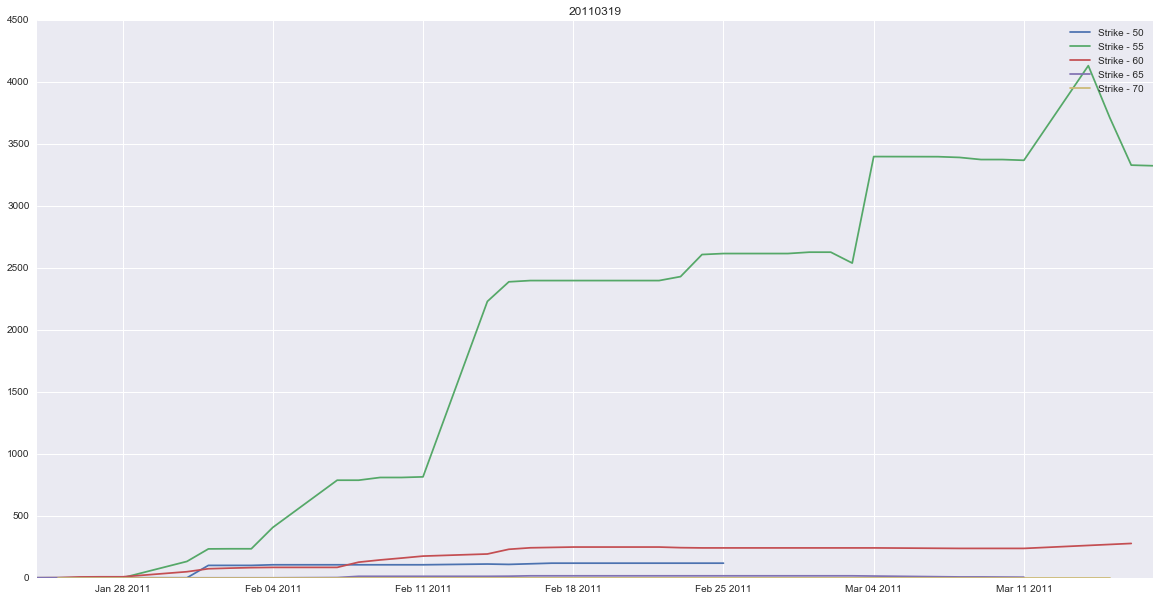

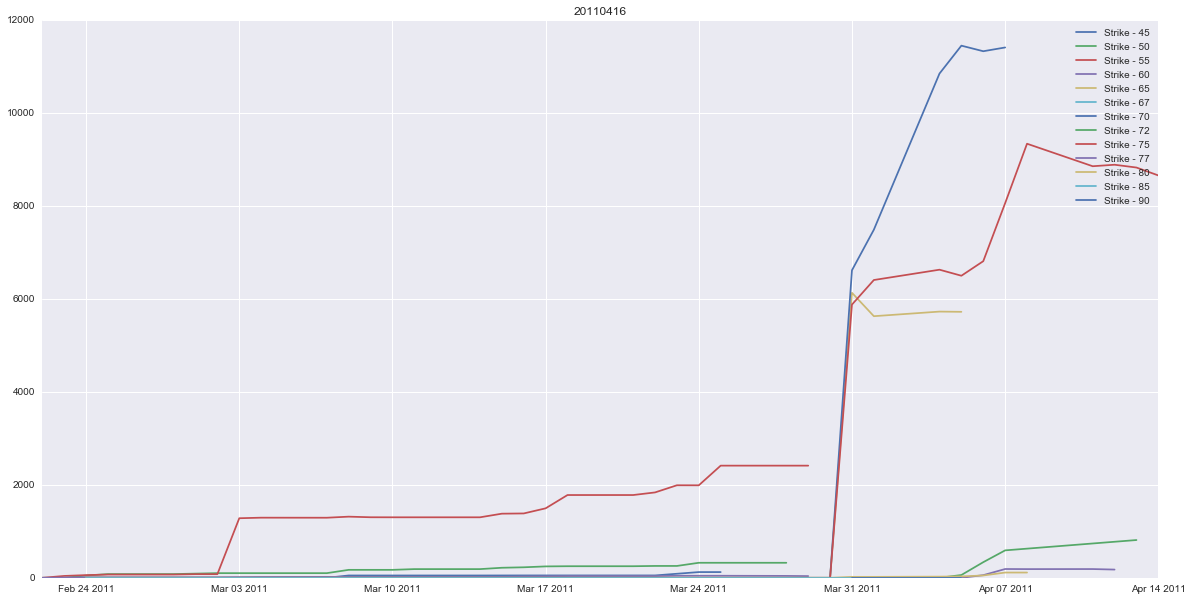

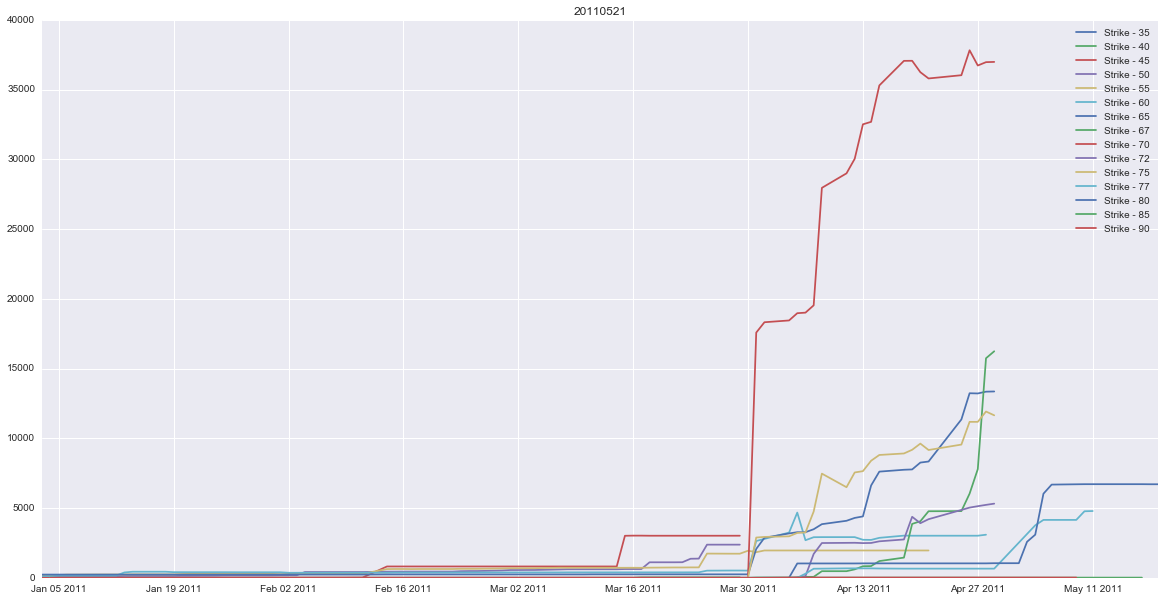

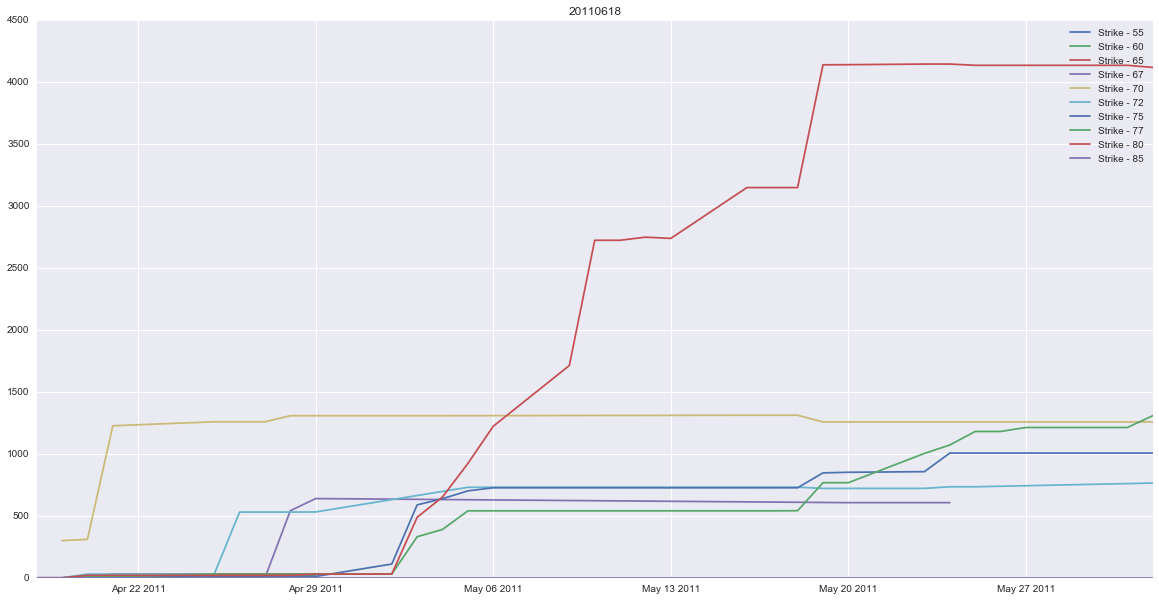

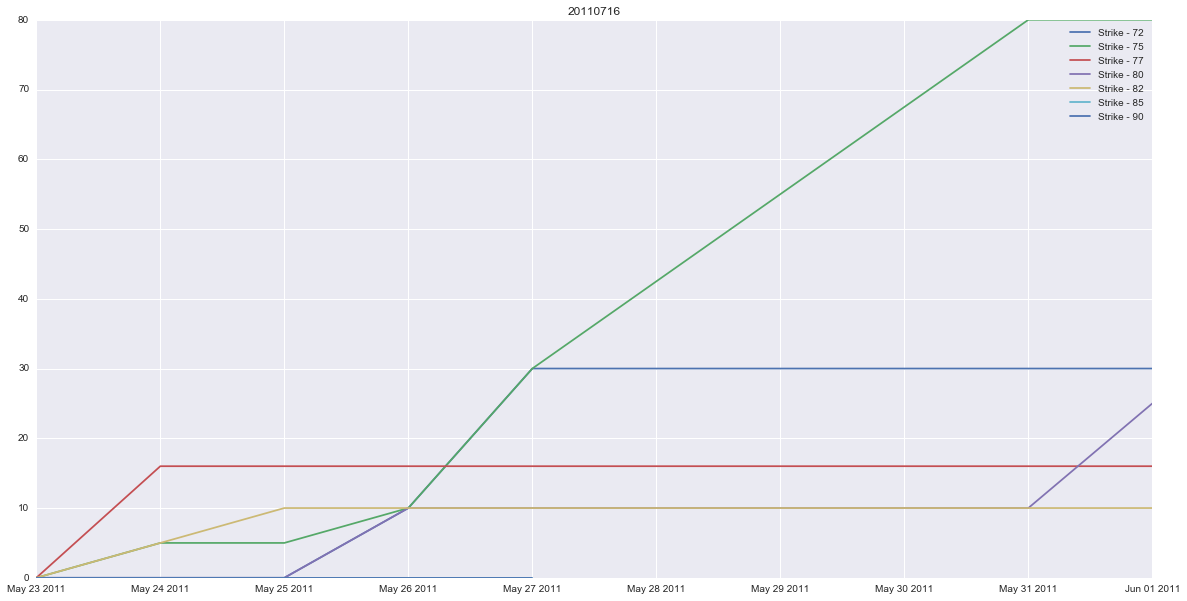

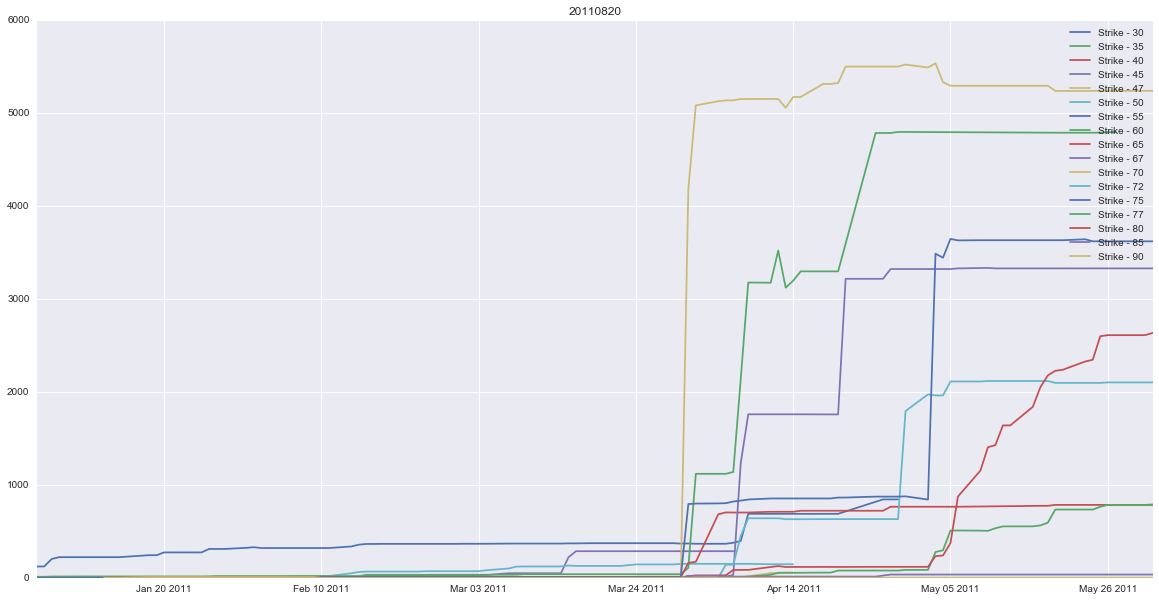

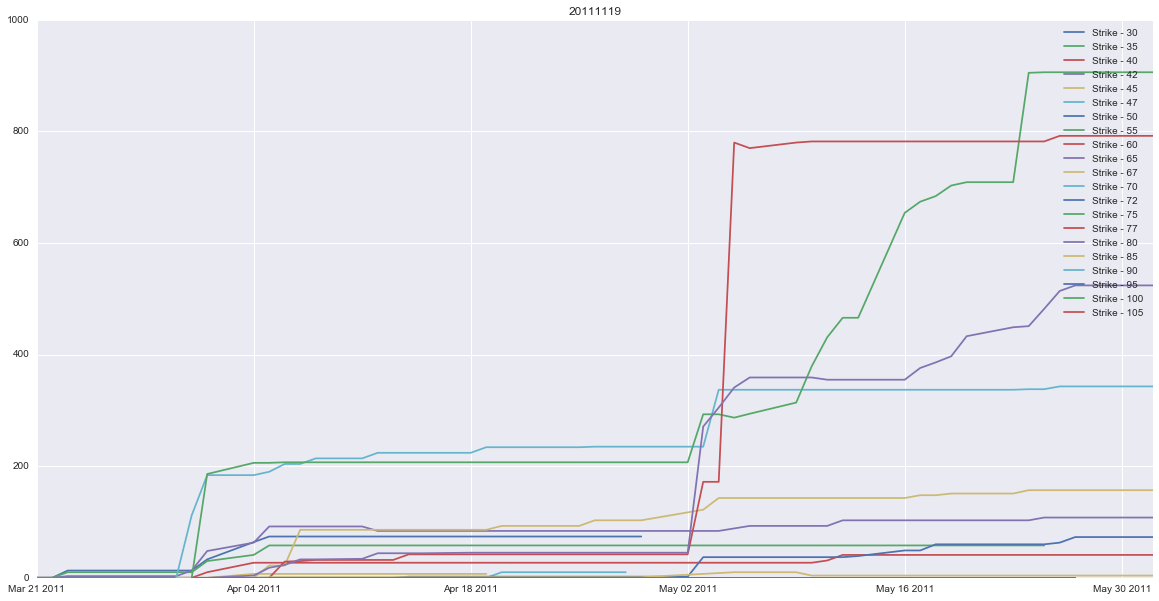

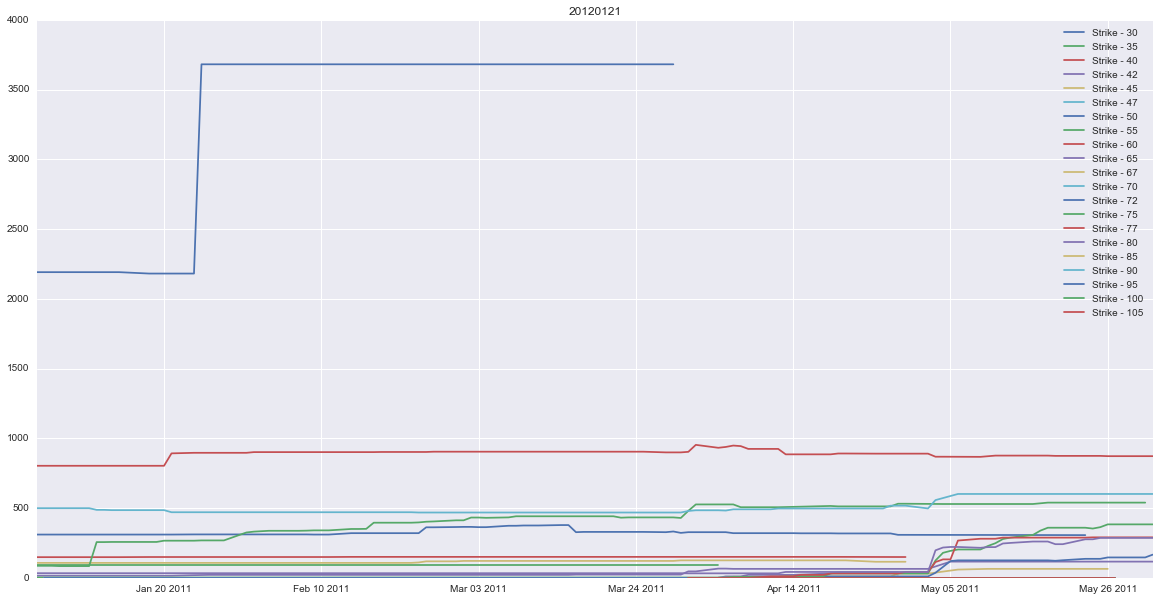

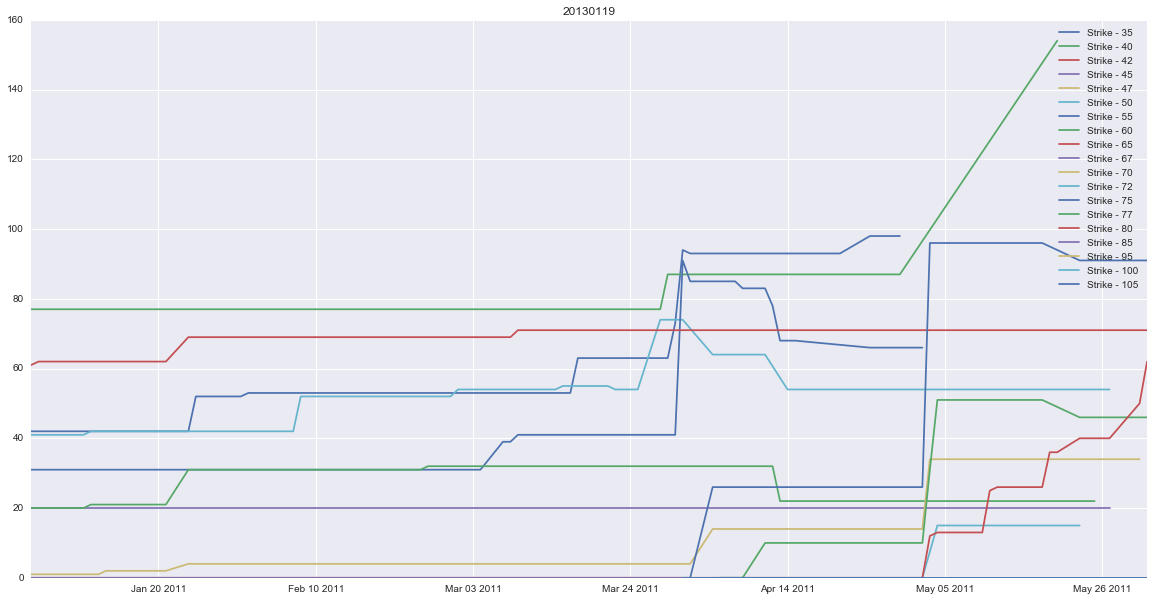

In [442]:
# Open interest by expiration, puts
for idx, row in ceph_data_p.groupby(['Expiration']):
    plt.figure()
    for jdx, row2 in row.groupby('Strike'):
        lab = 'Strike - '+str(int(jdx))
        plt.plot(row2['Date'],row2['OpenInterest'],label=lab)
    plt.title(idx.strftime('%Y%m%d'))
    plt.gcf().set_size_inches(20, 10)
    plt.legend()
    plt.show()

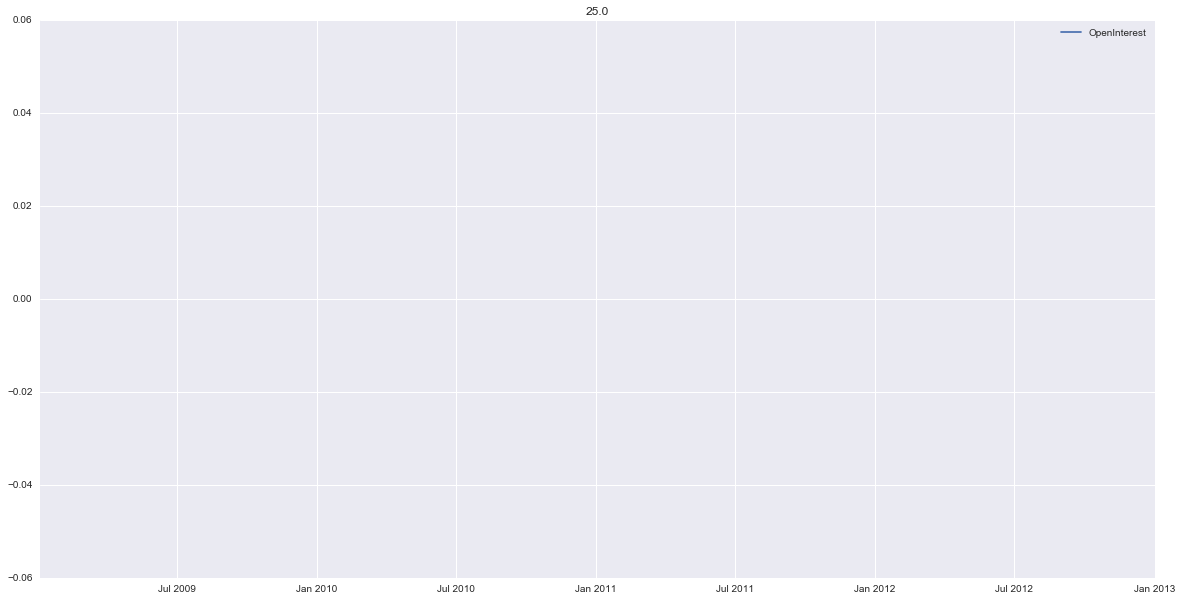

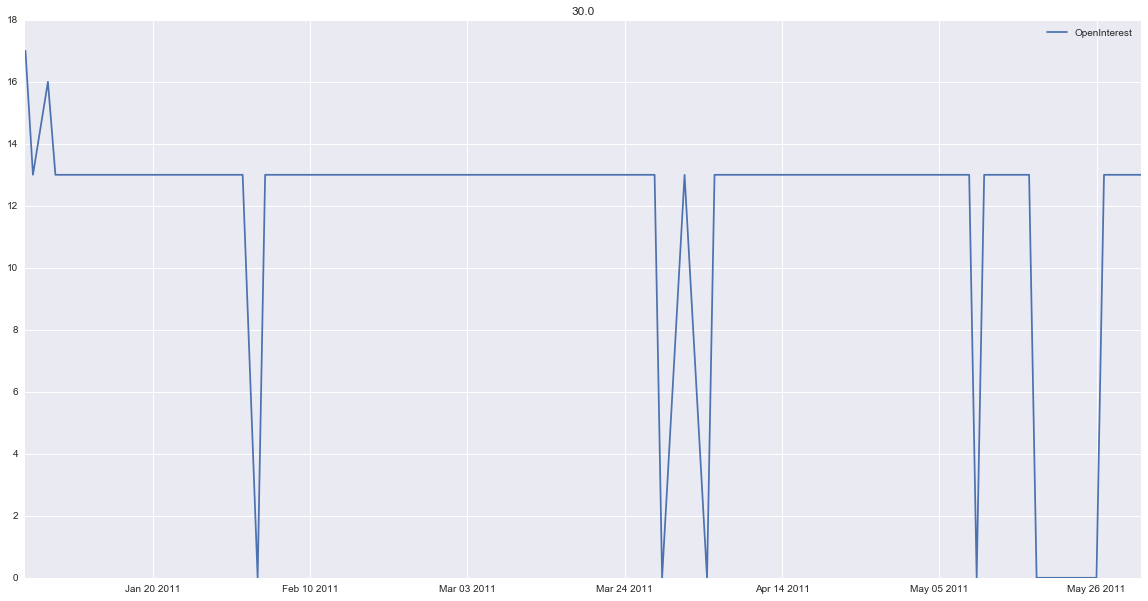

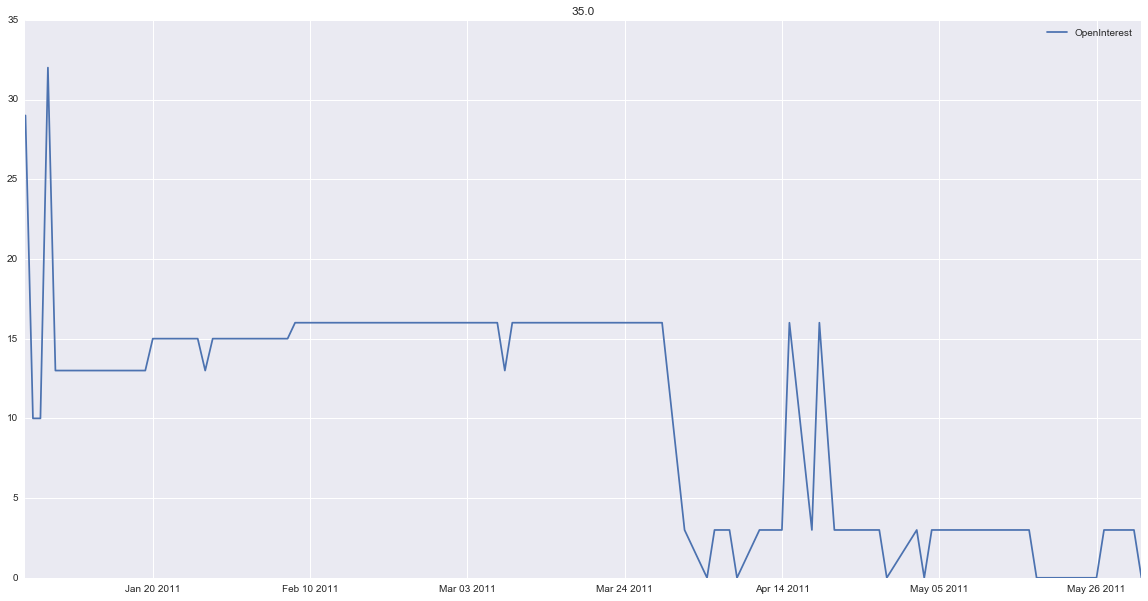

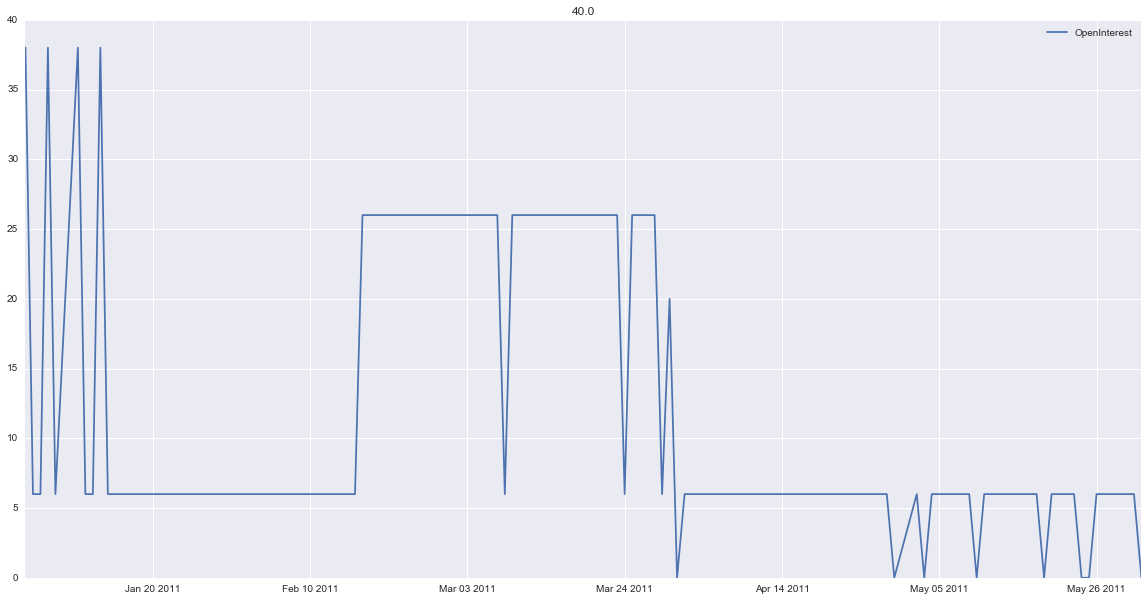

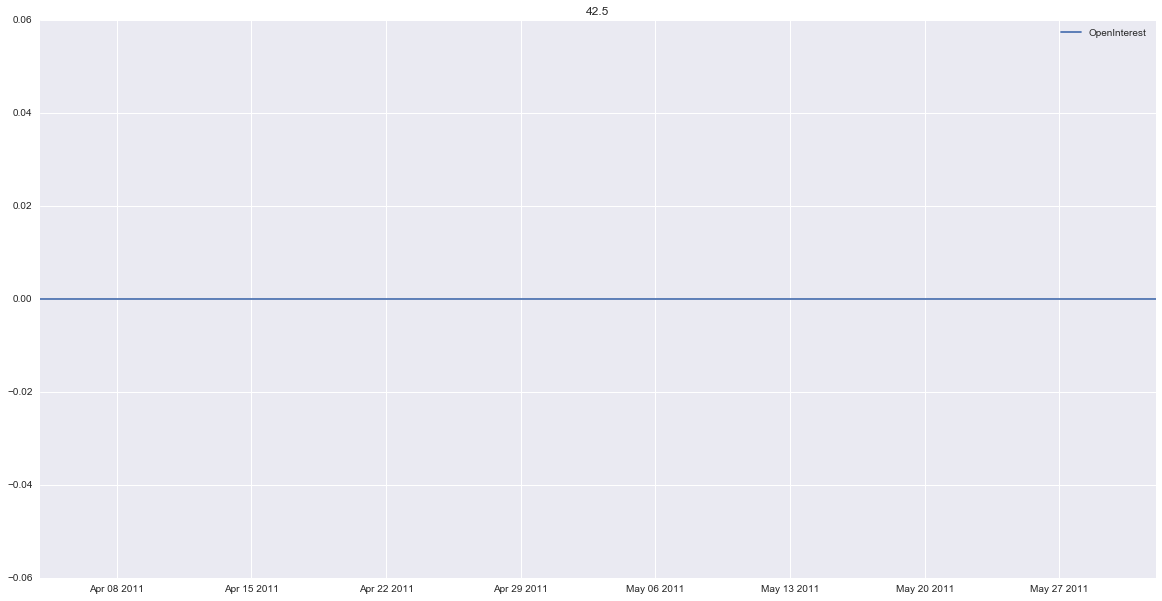

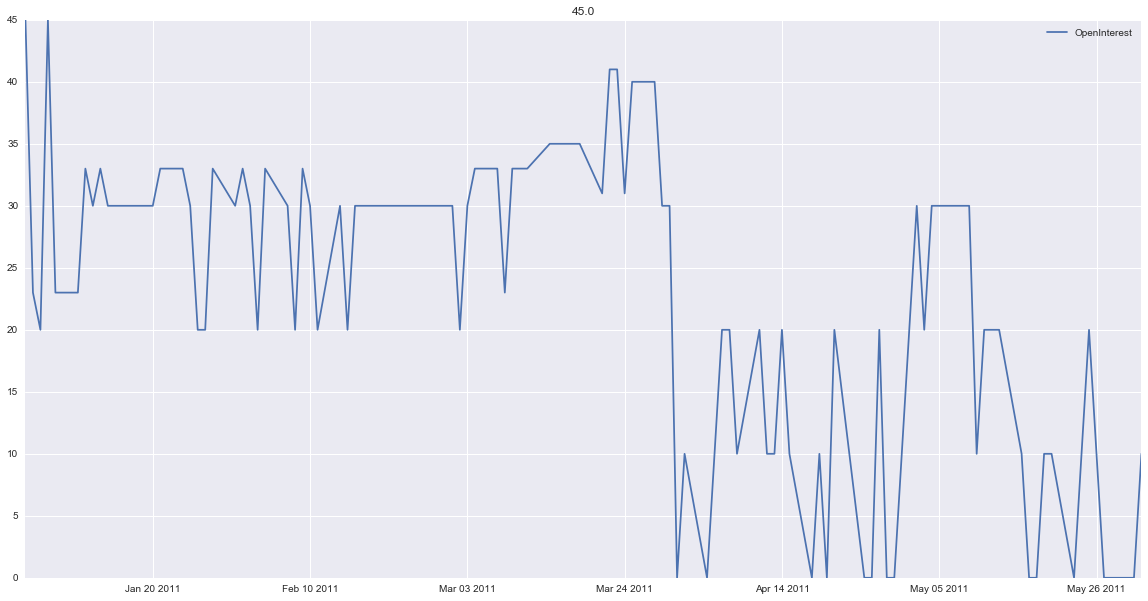

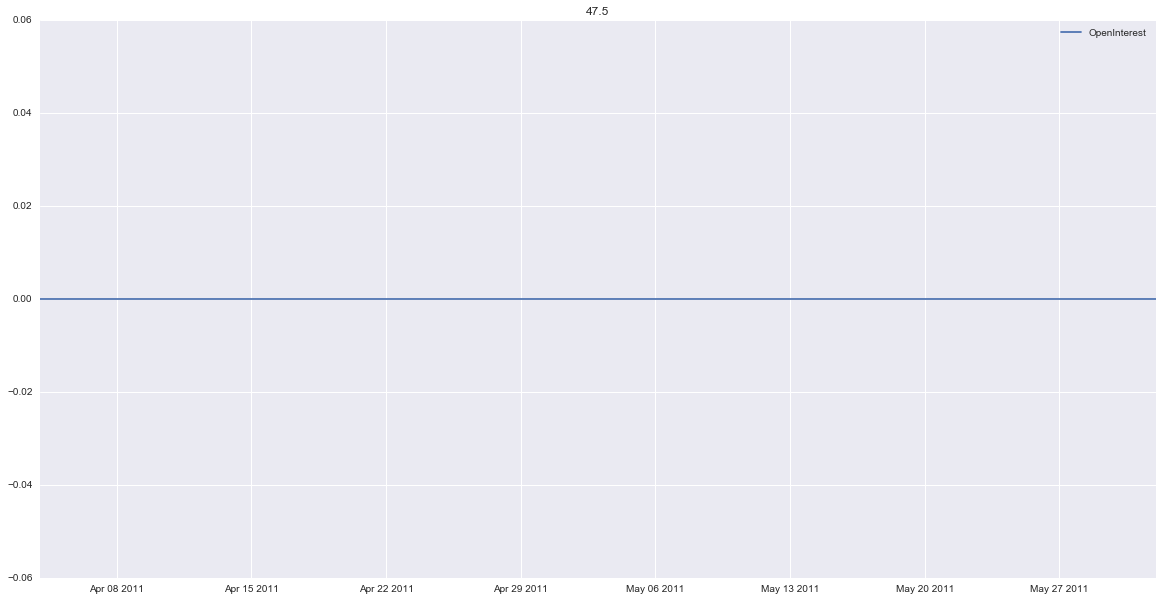

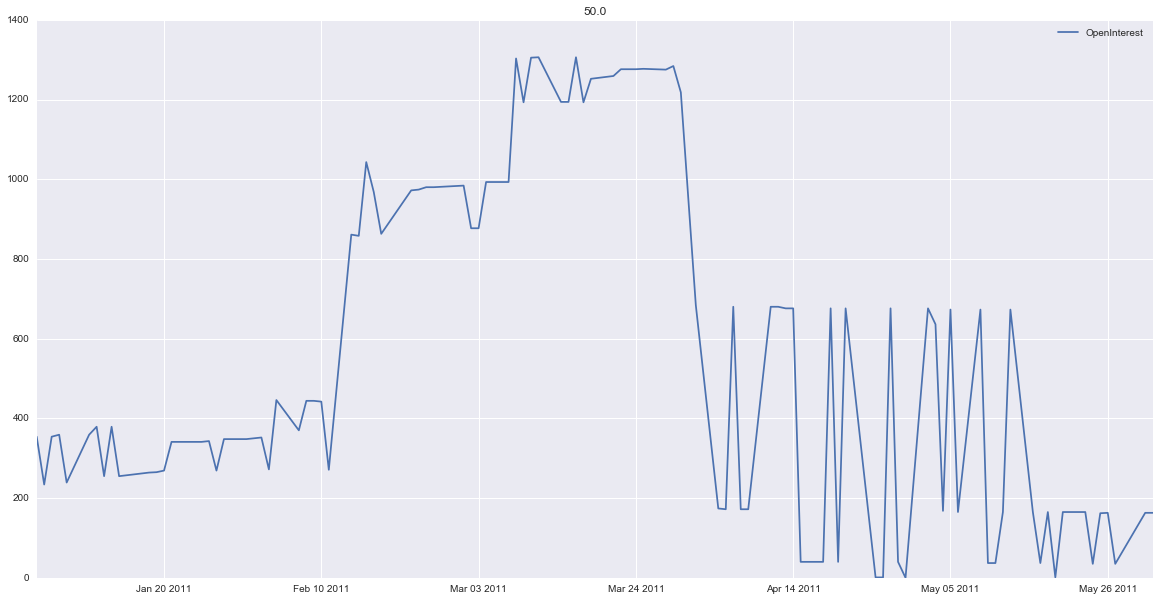

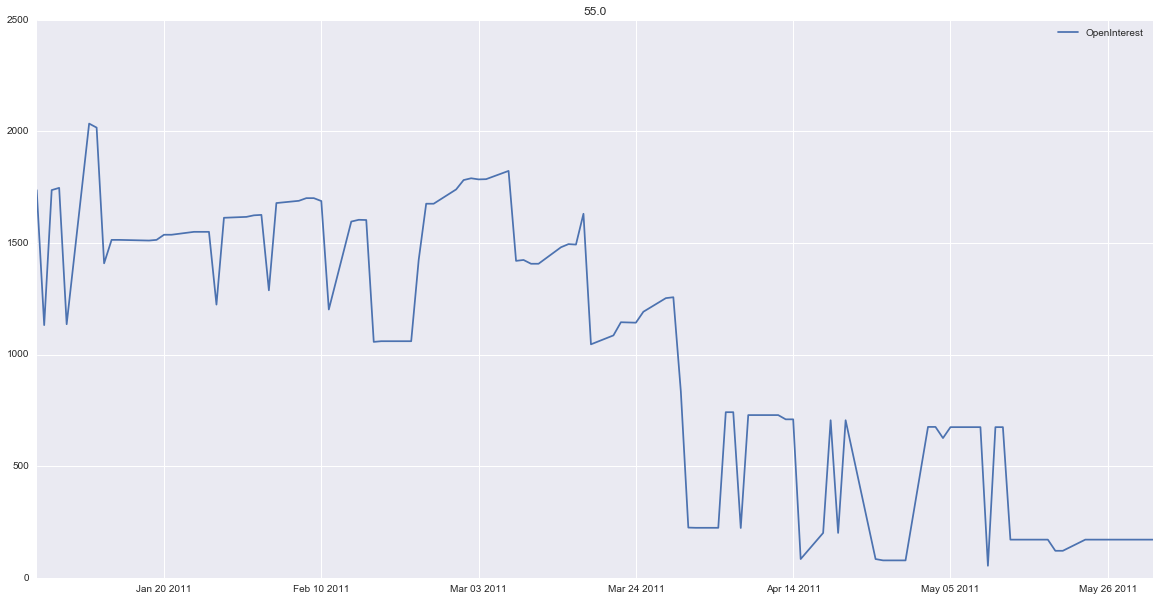

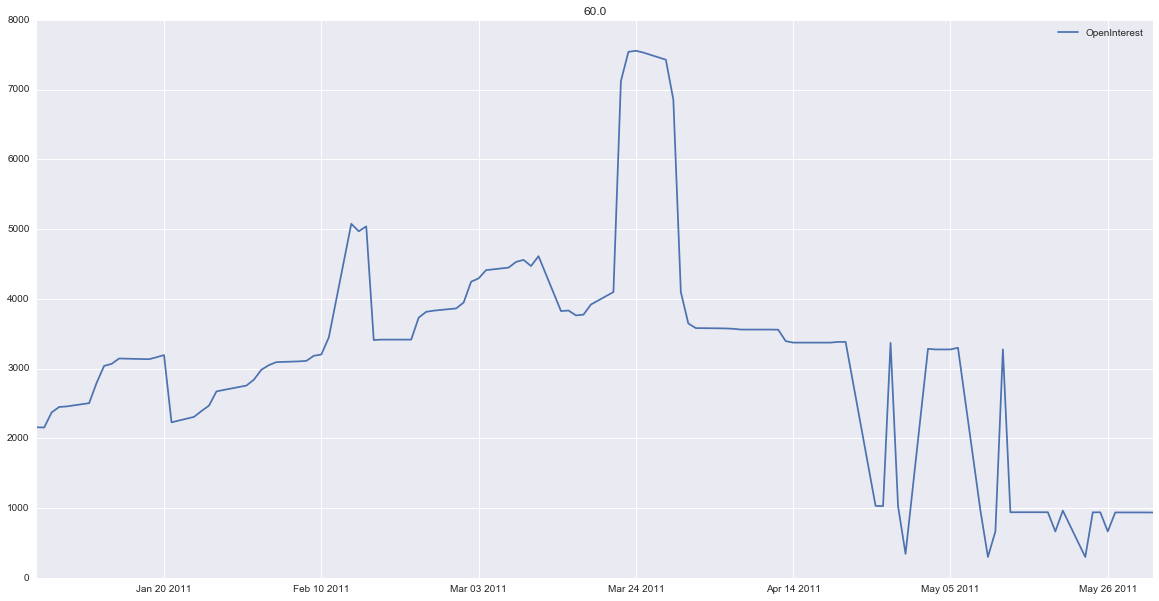

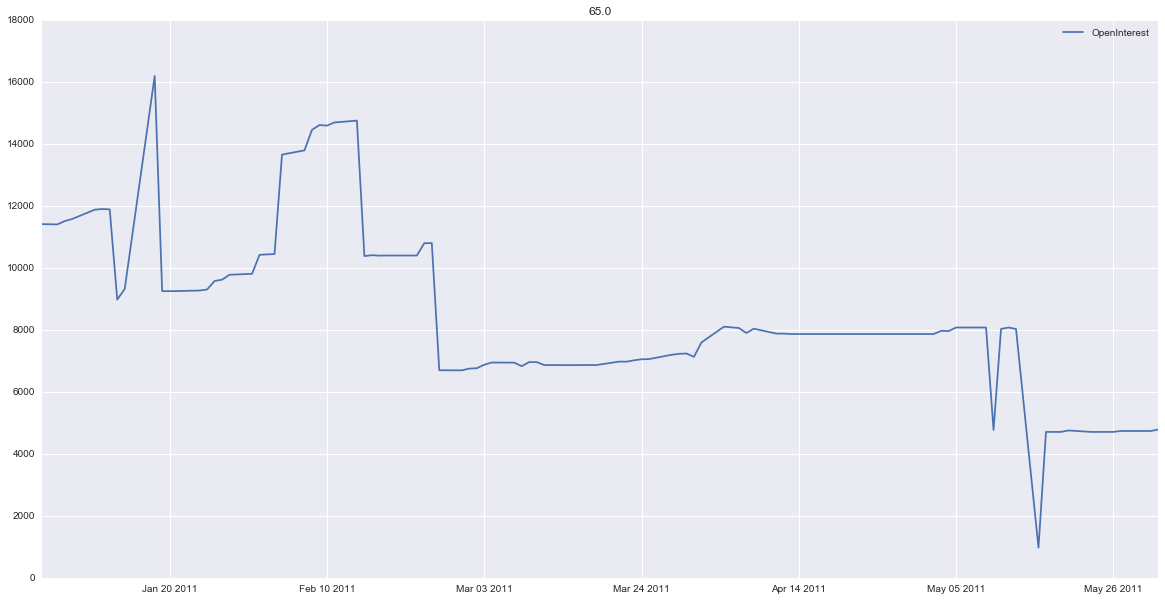

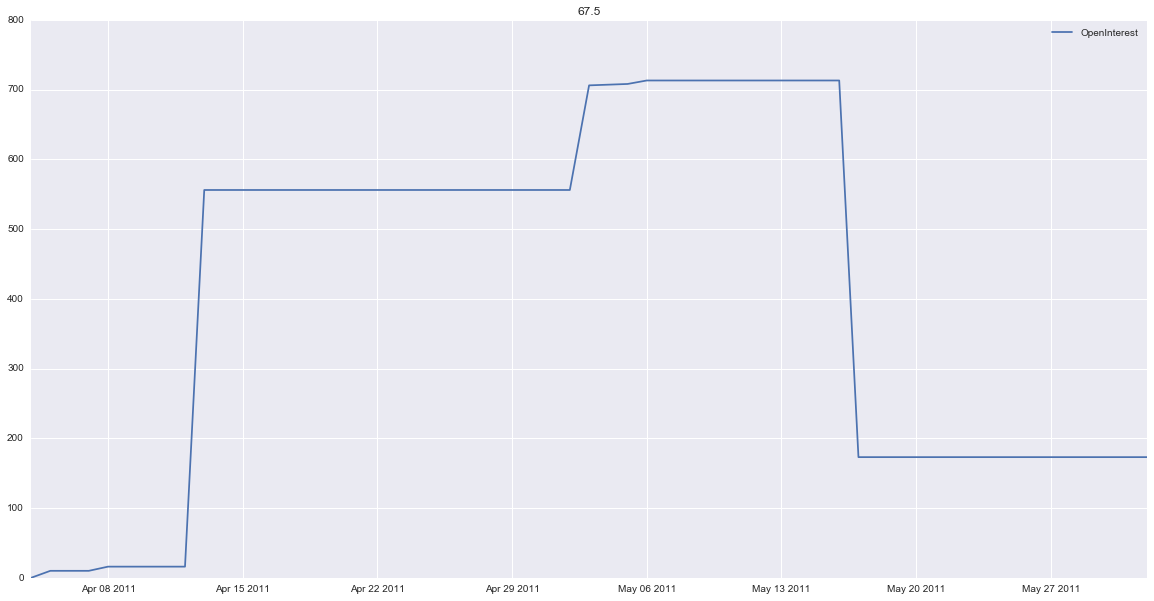

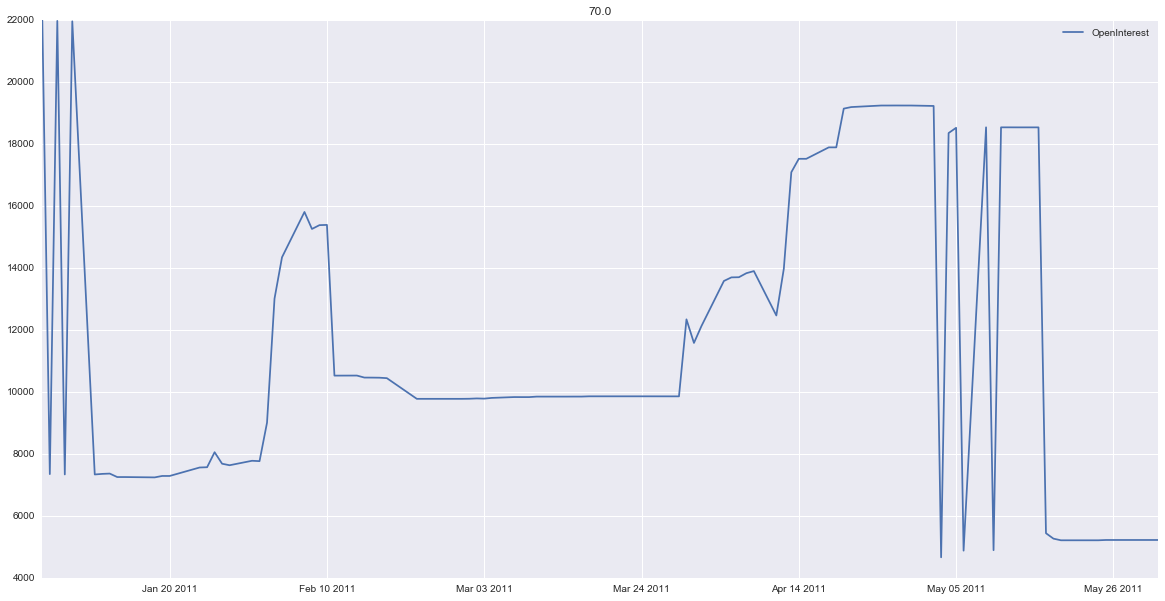

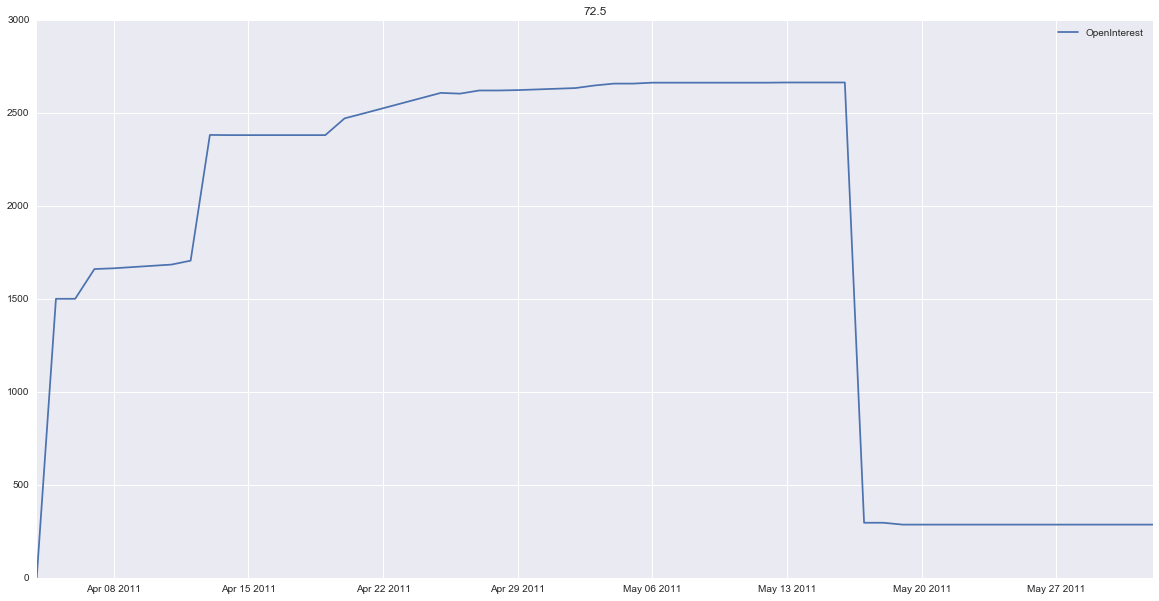

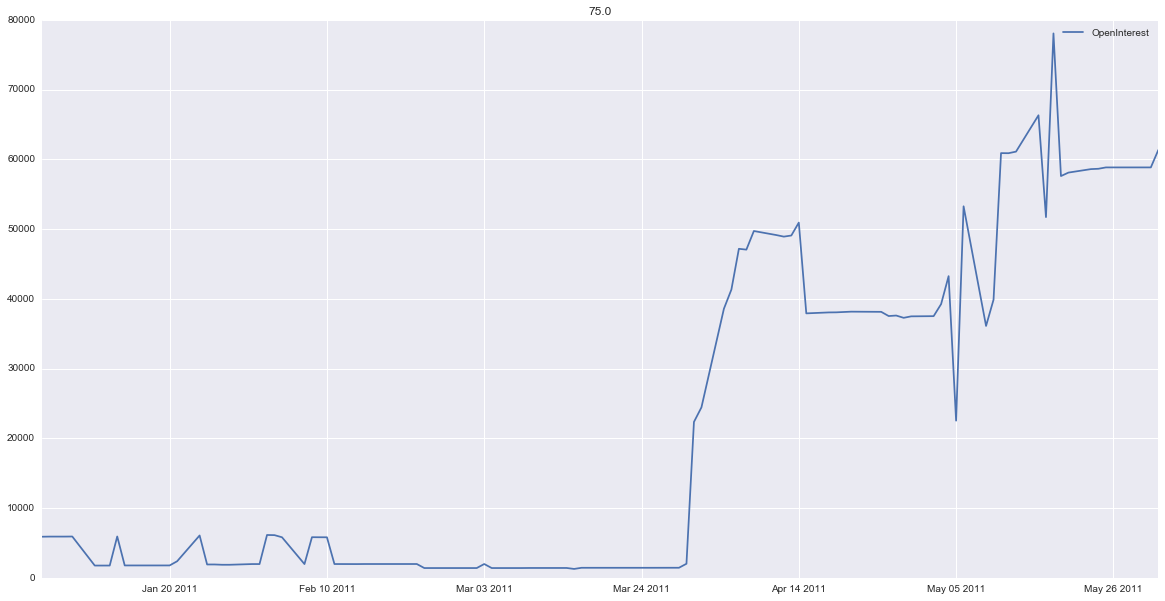

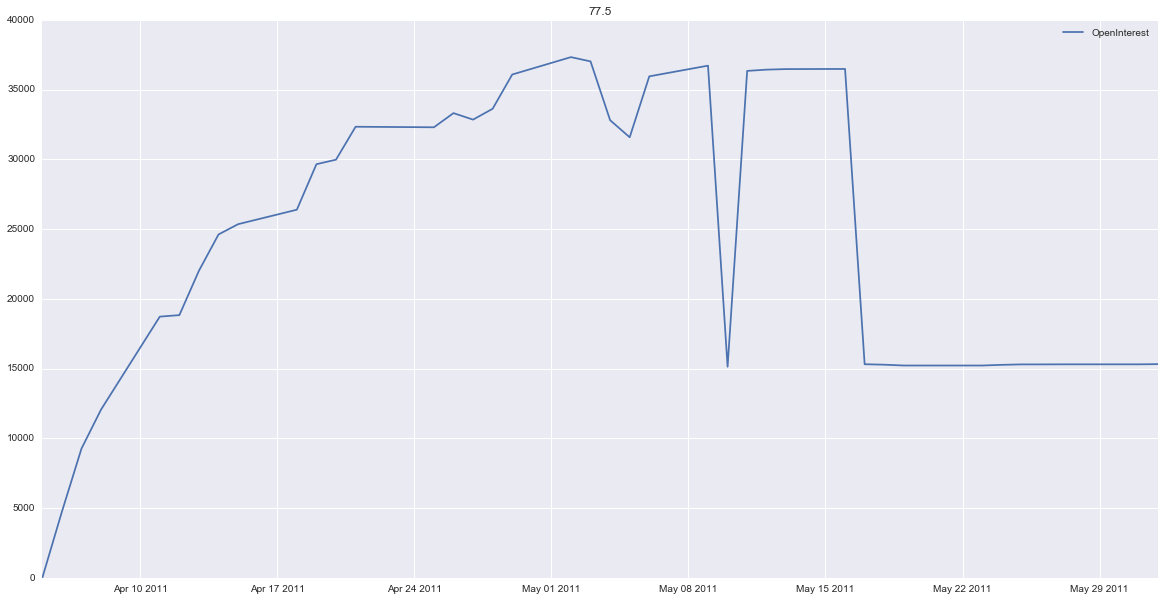

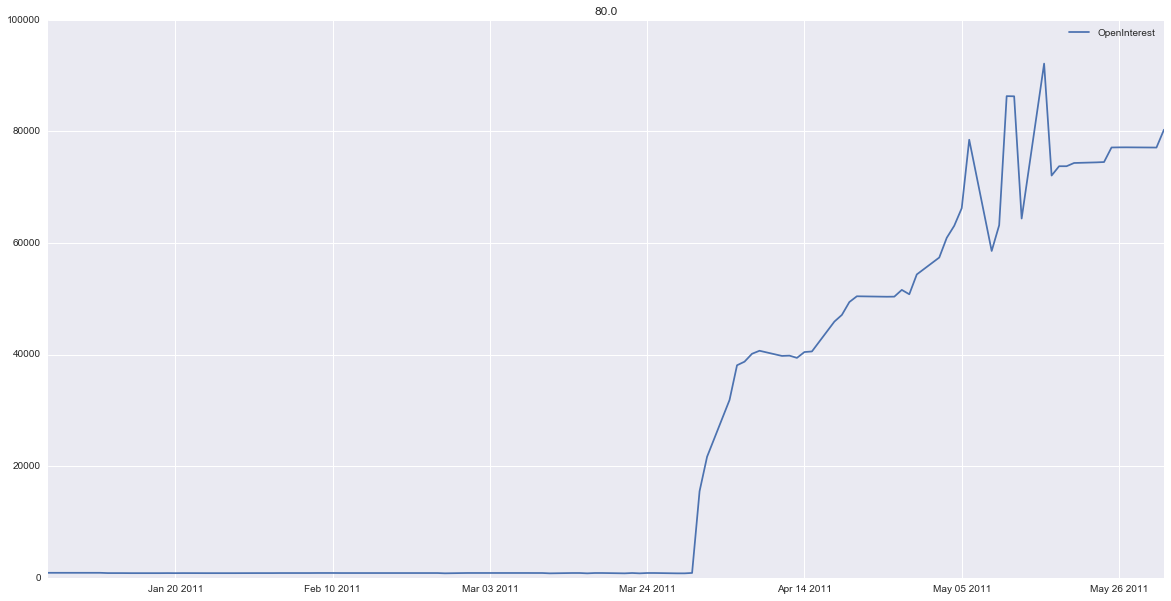

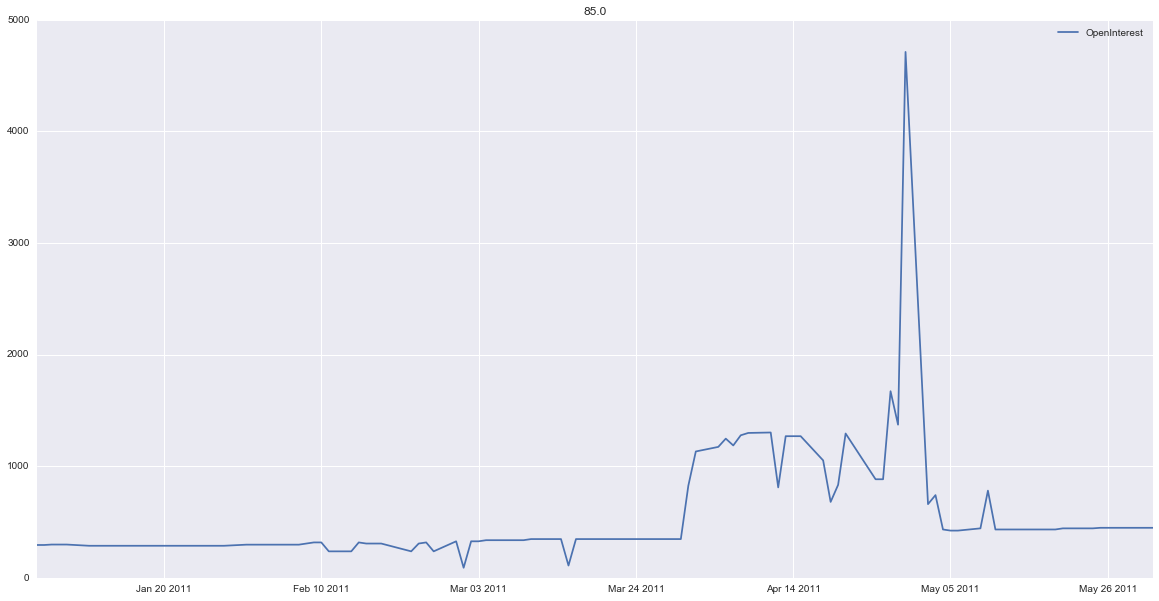

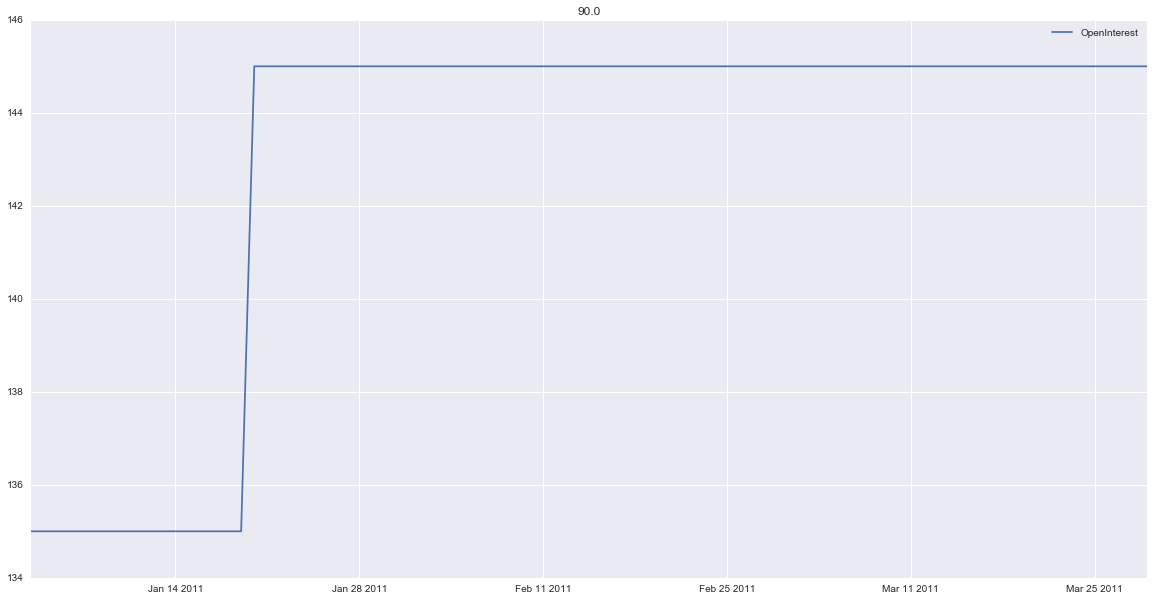

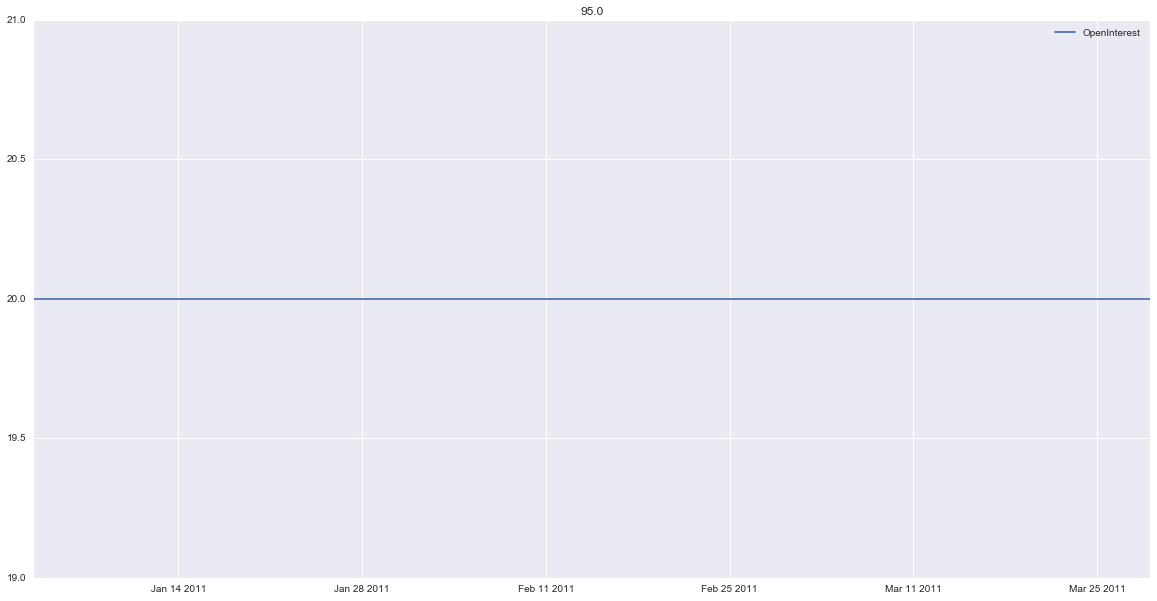

In [443]:
# Open Interest by strike, calls
for idx, row in ceph_data_c.groupby('Strike'):
    t_ = row.groupby('Date').sum()['OpenInterest']
    plt.figure()
    #plt.plot(row['Date'],row['OpenInterest'])
    plt.plot(t_)
    plt.title(idx)
    plt.gcf().set_size_inches(20, 10)
    plt.legend()
    plt.show()

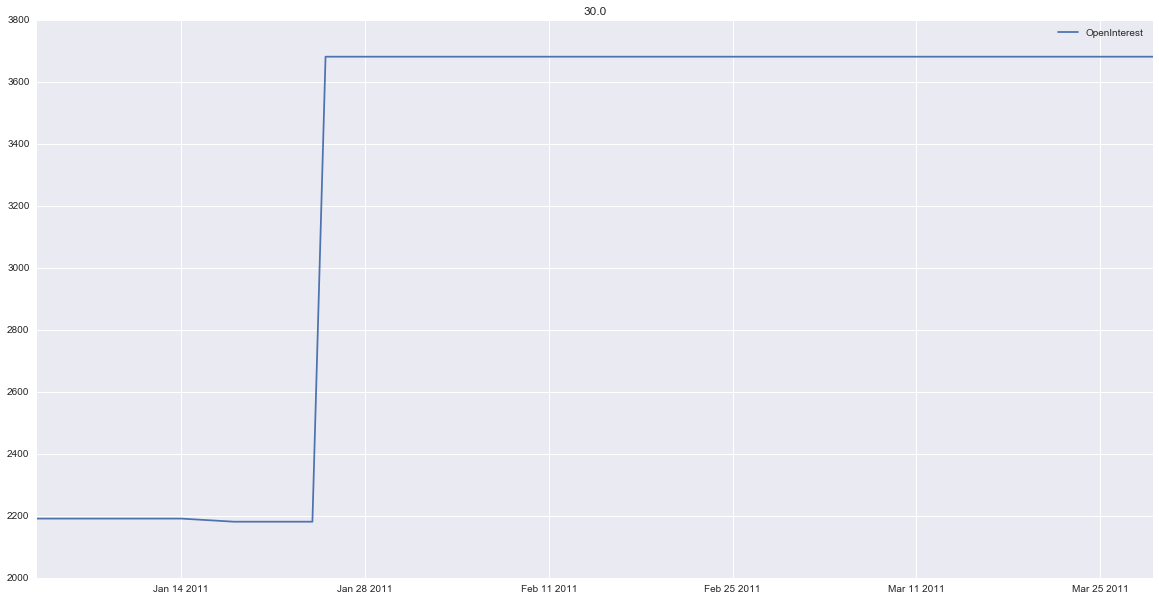

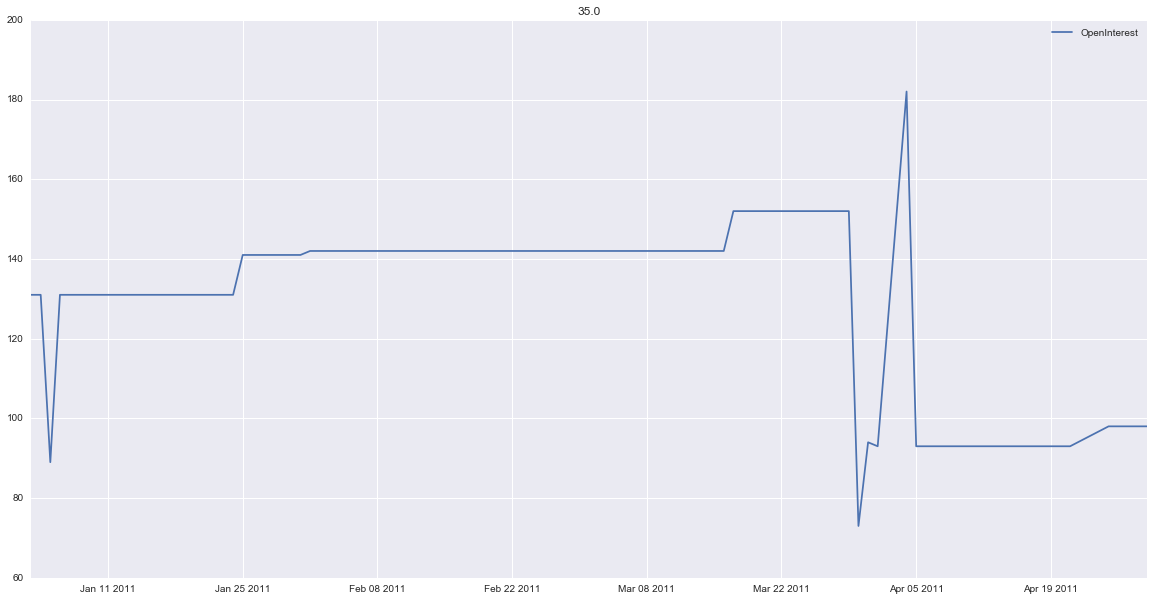

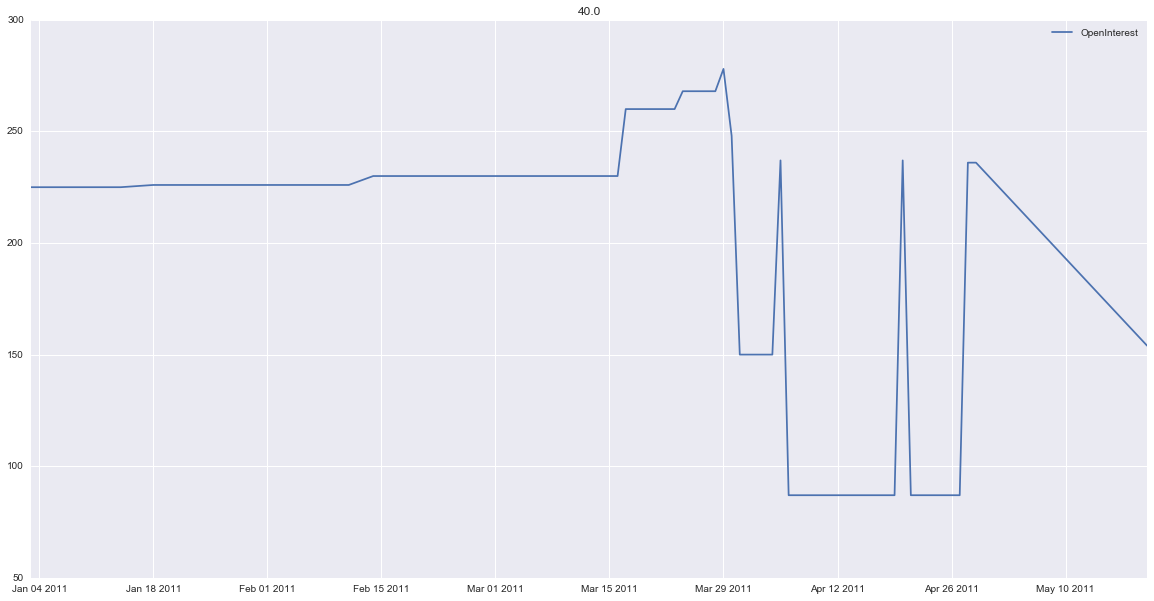

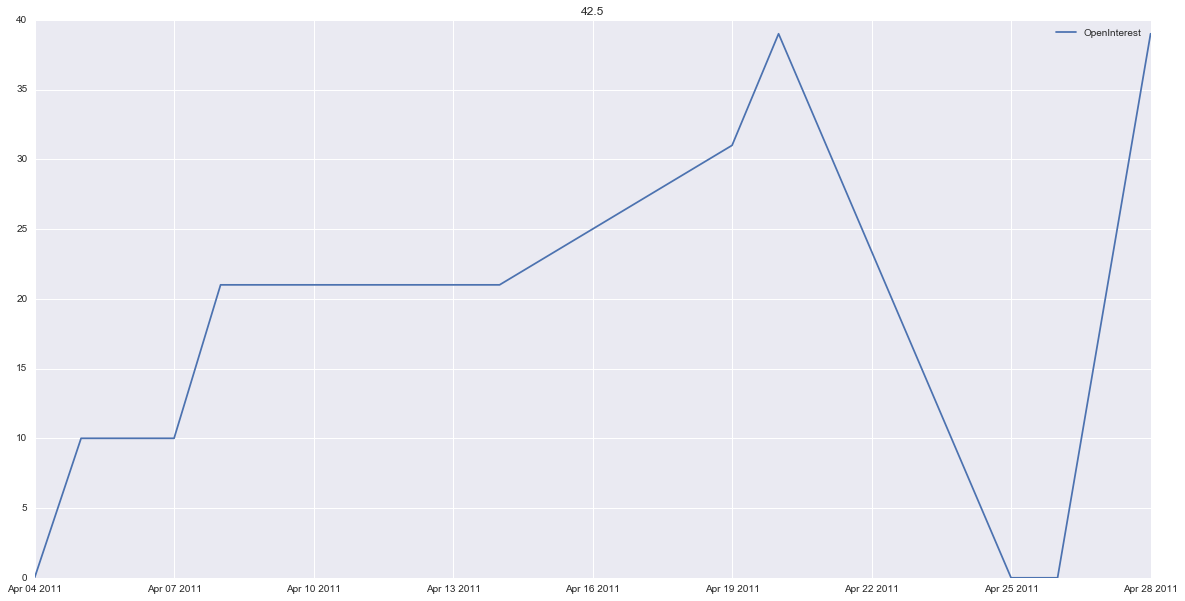

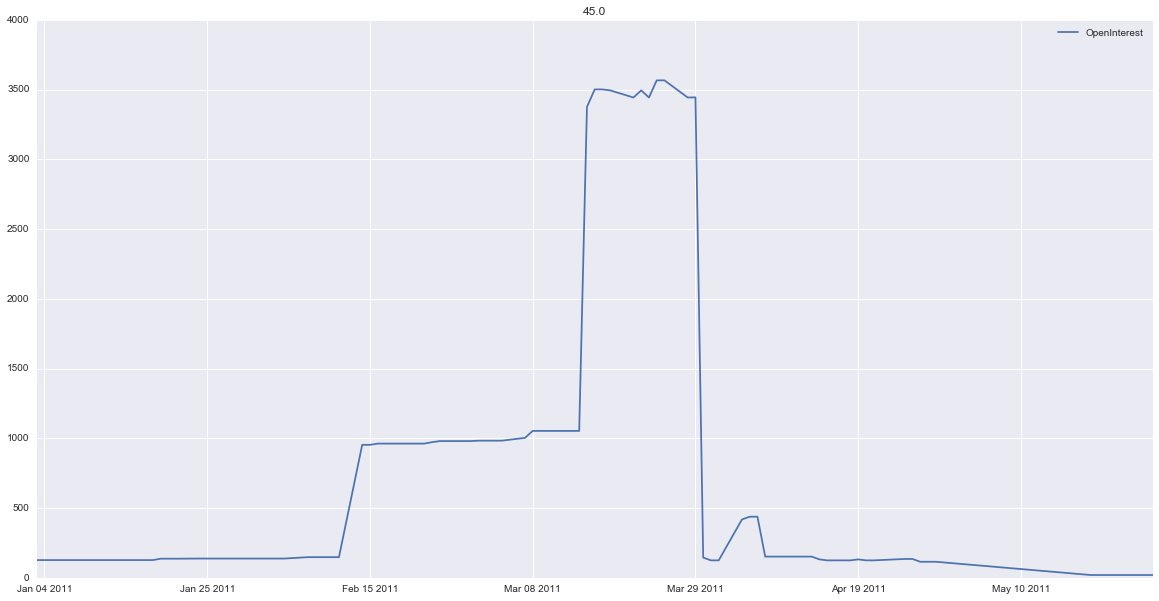

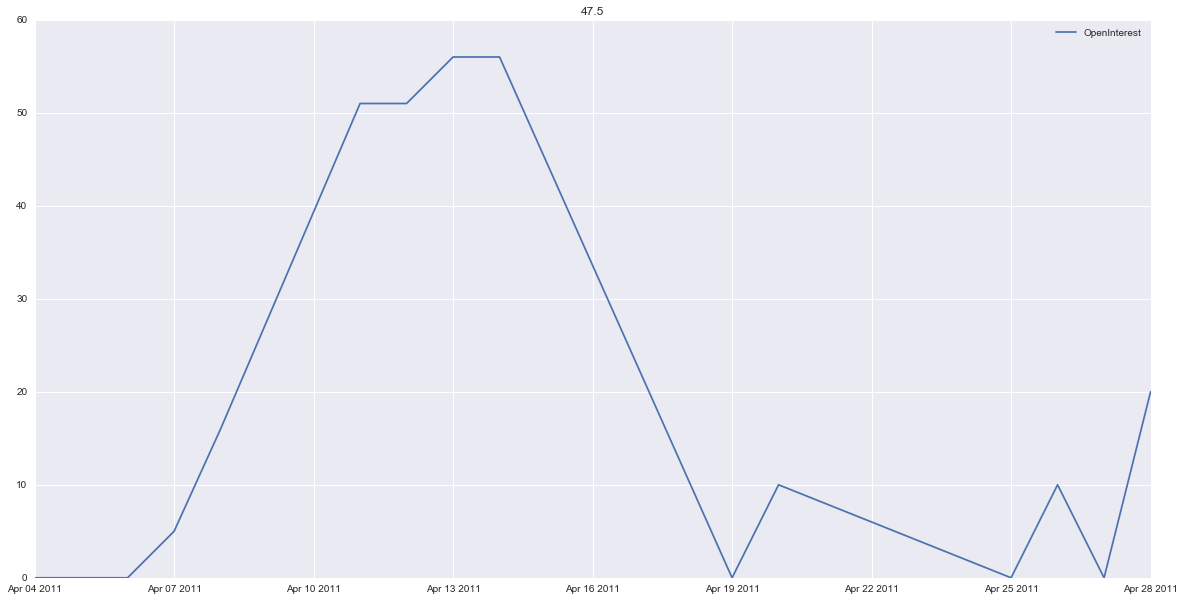

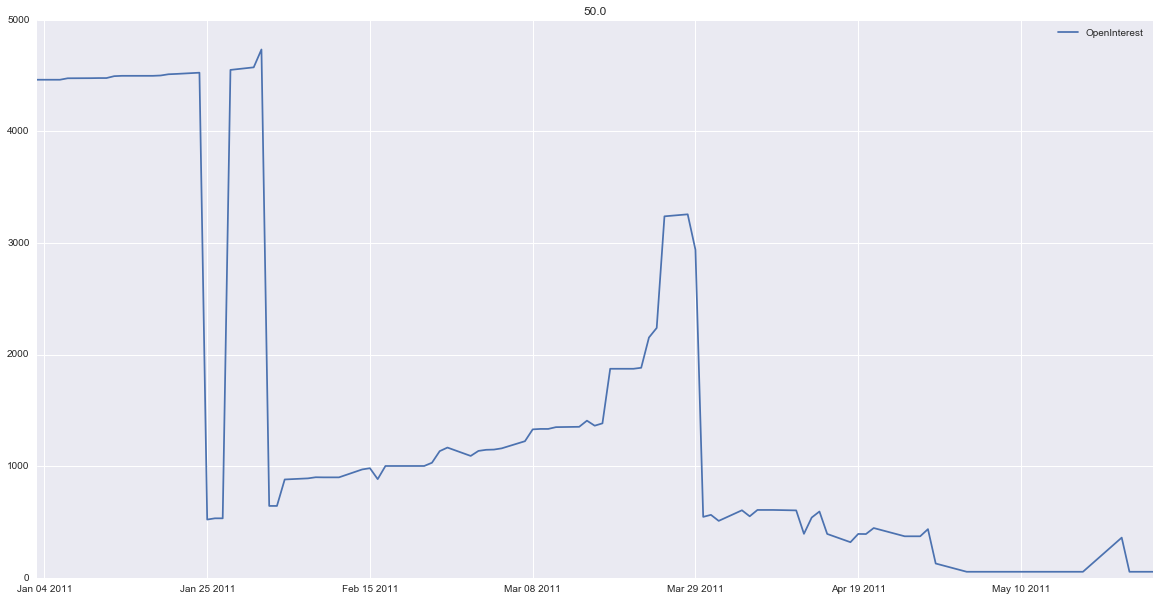

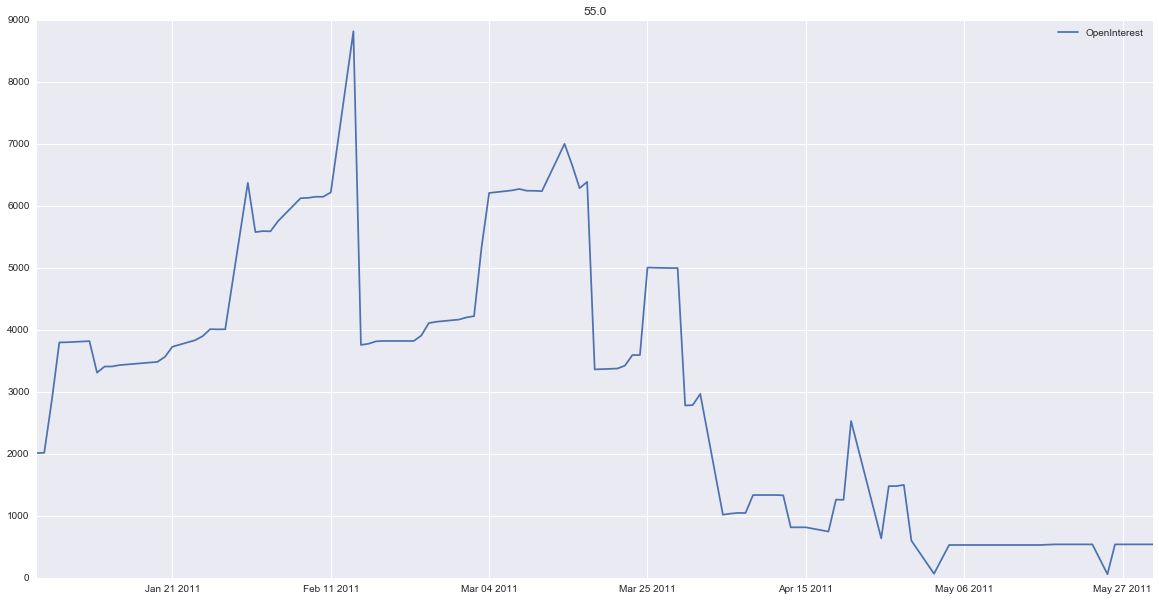

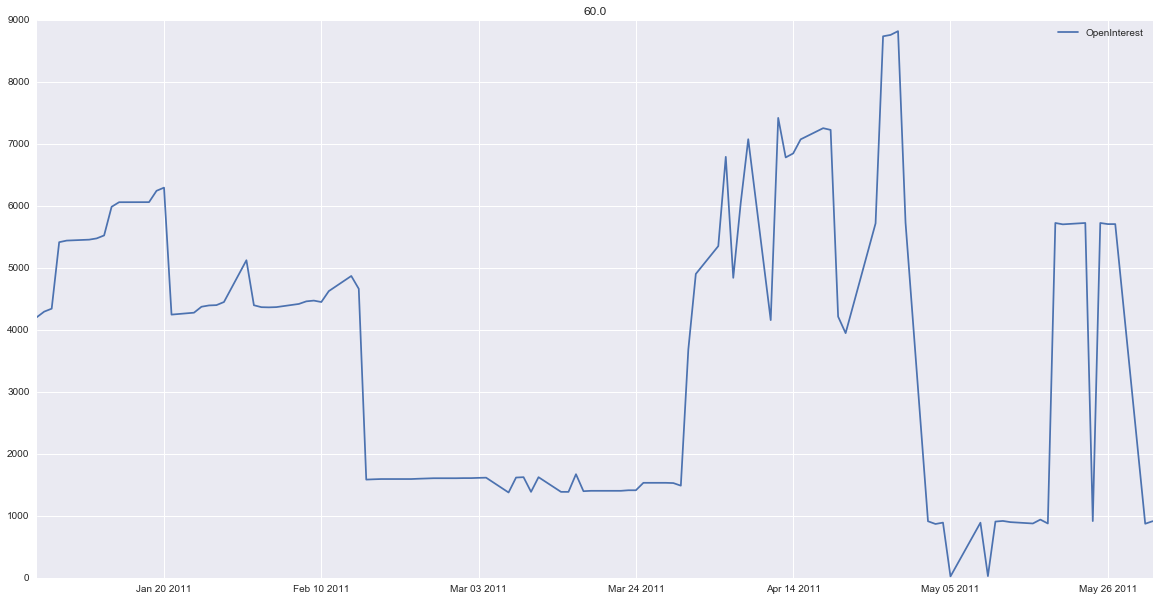

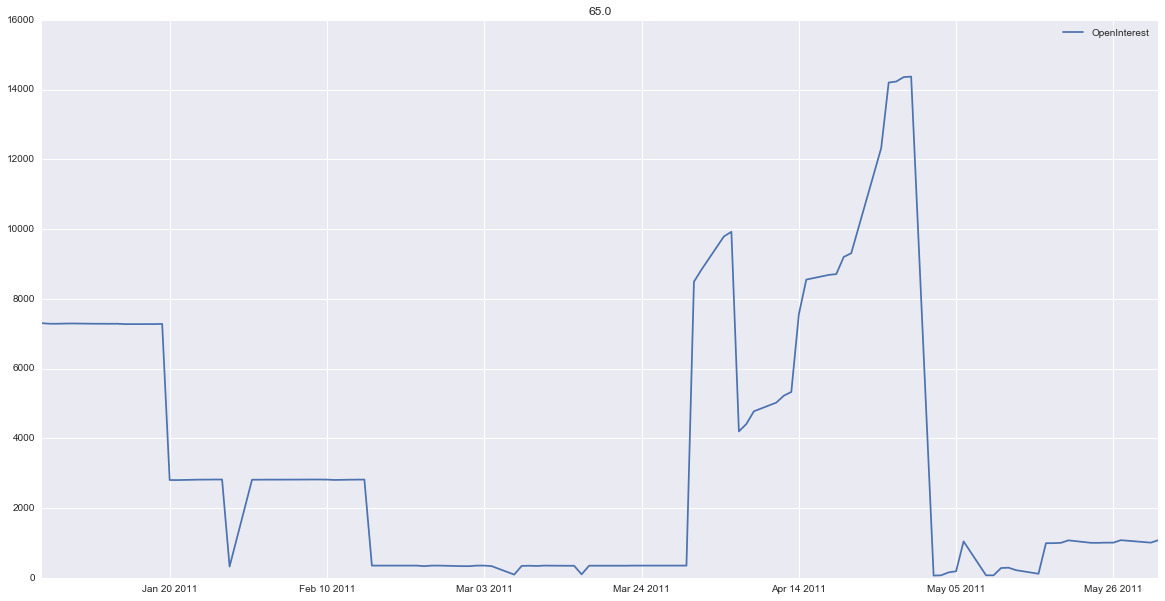

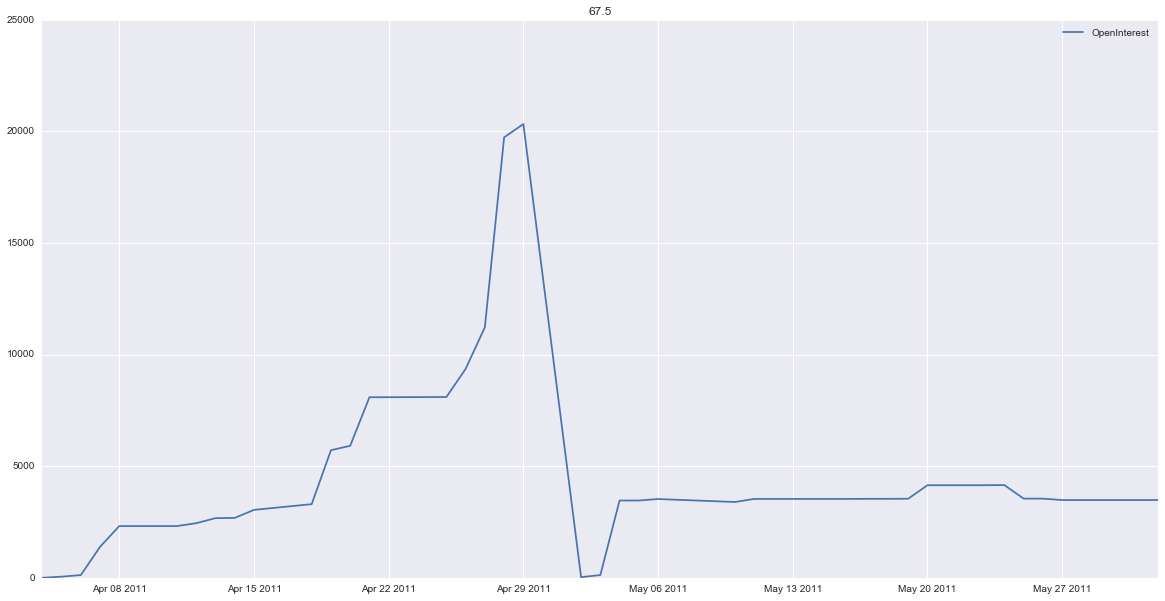

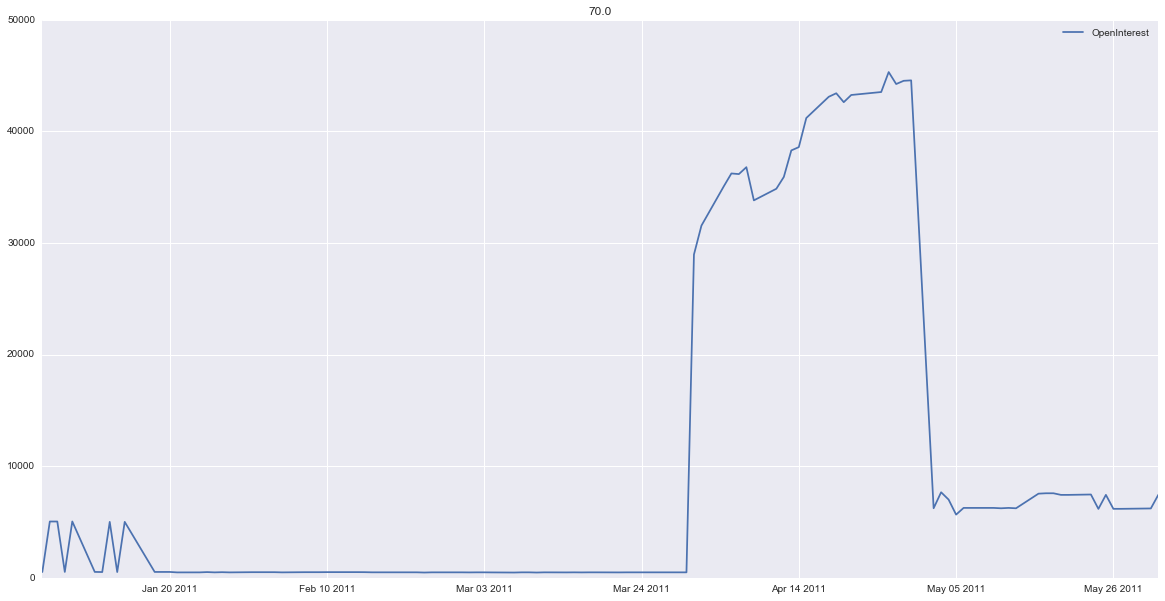

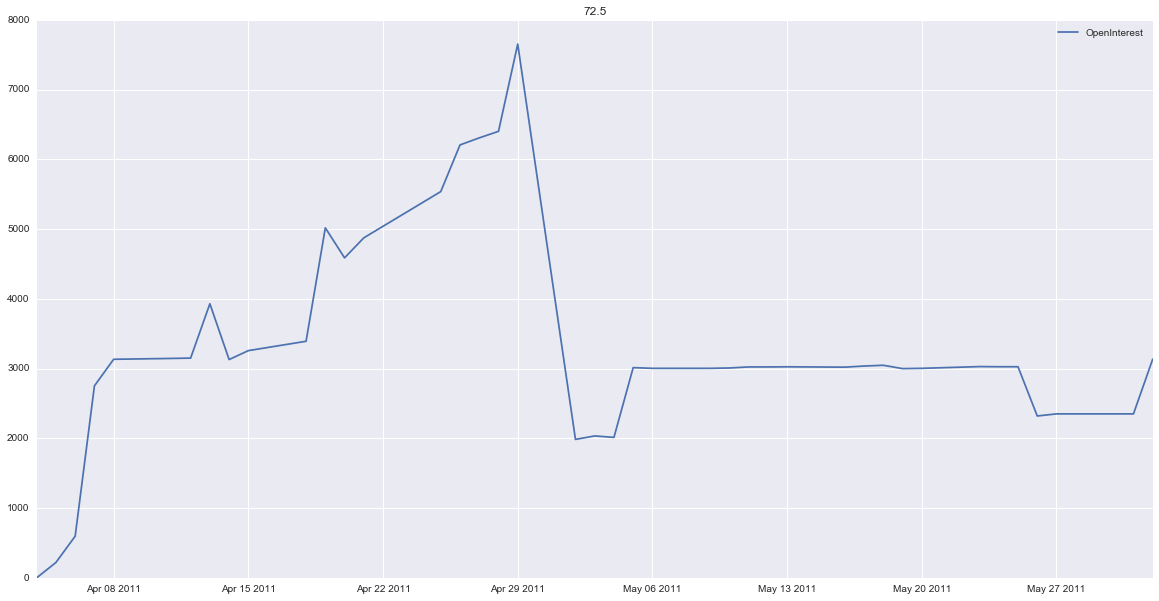

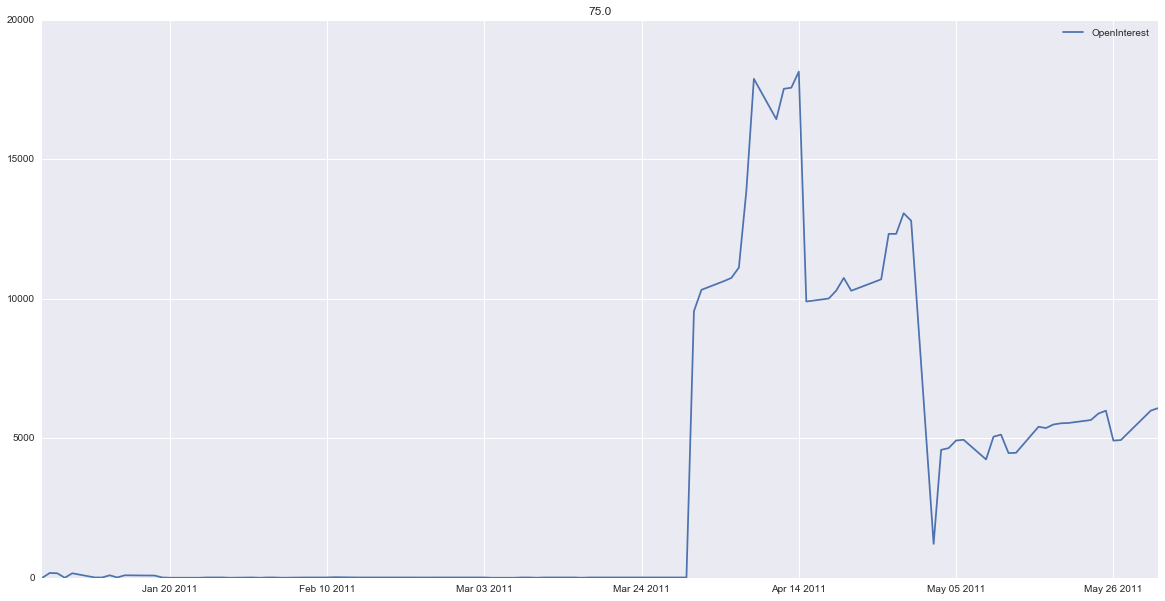

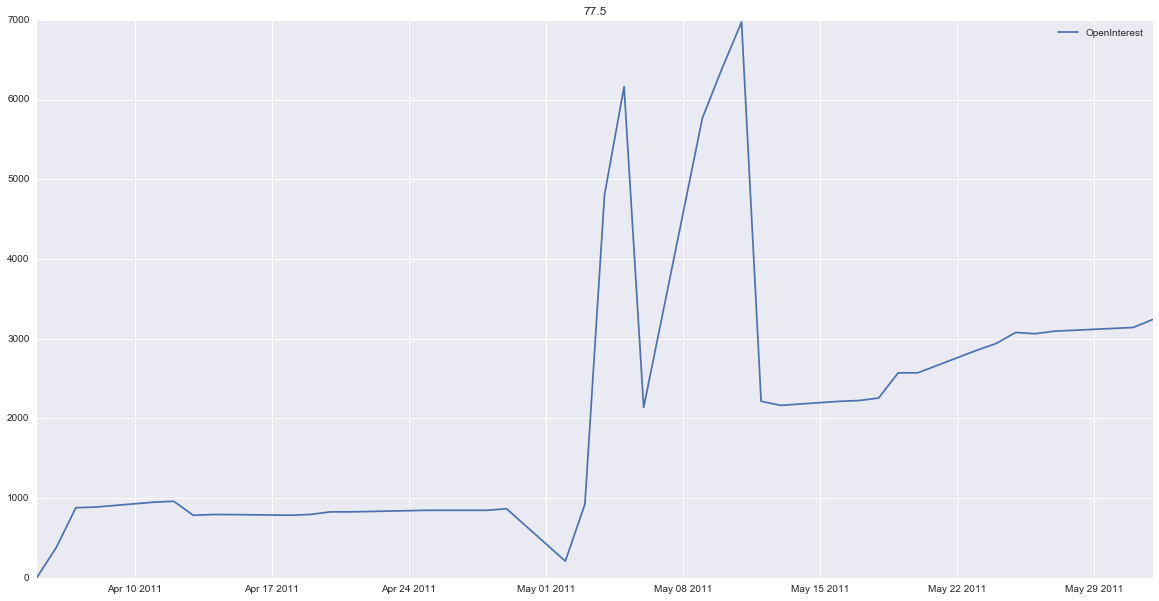

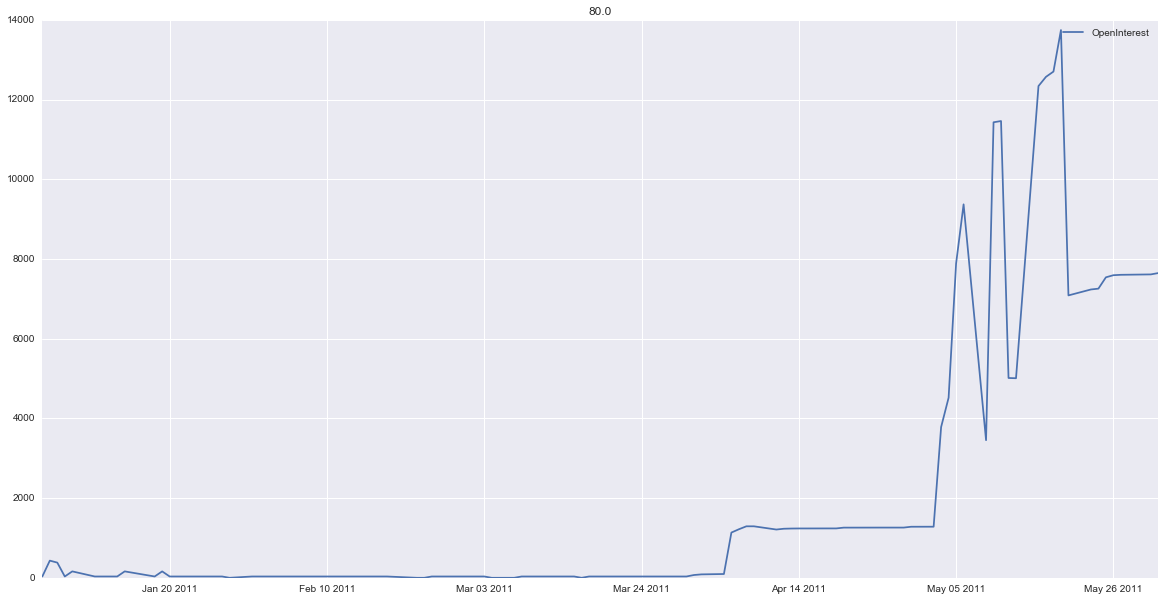

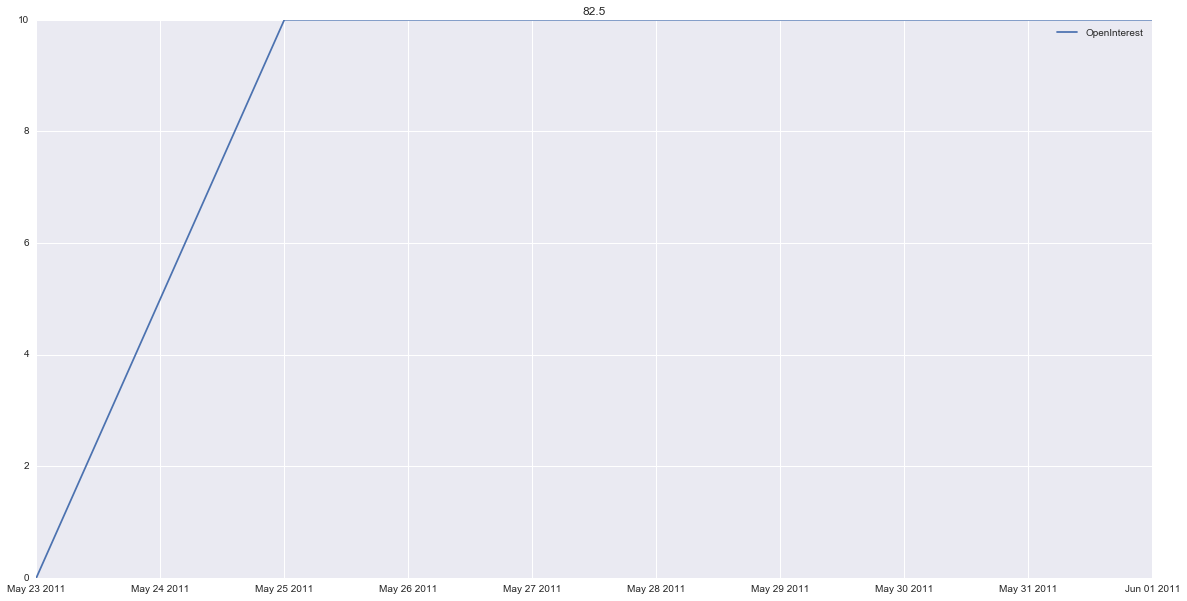

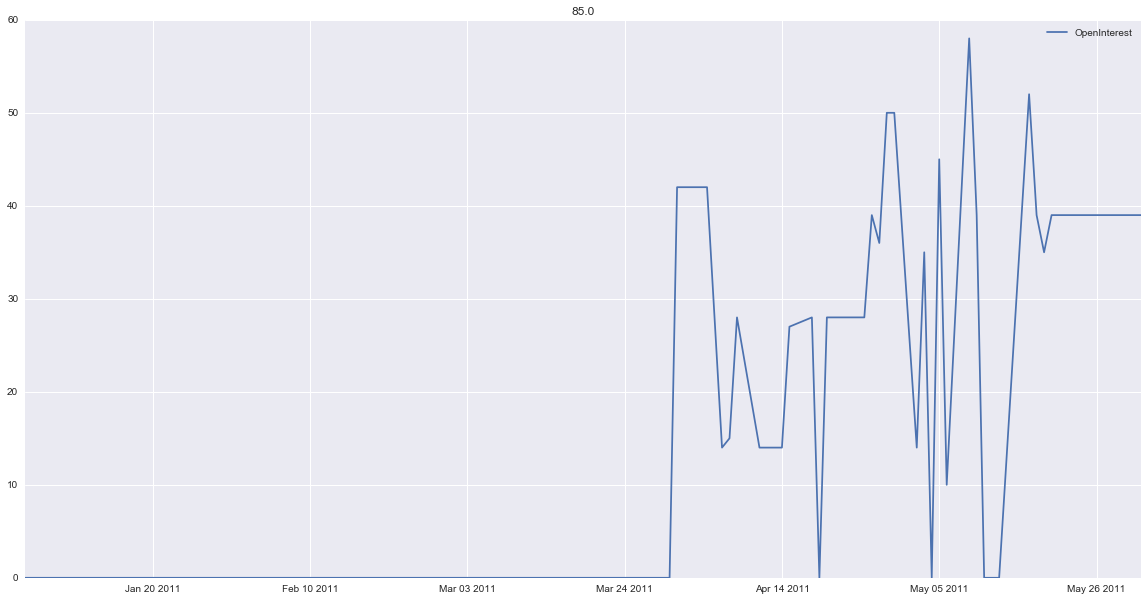

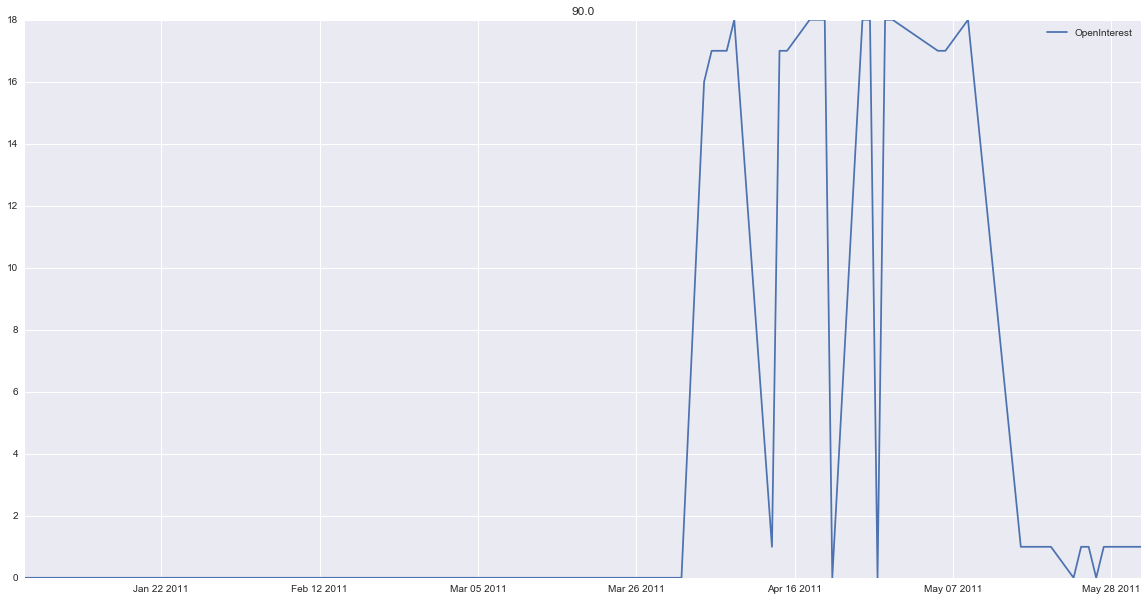

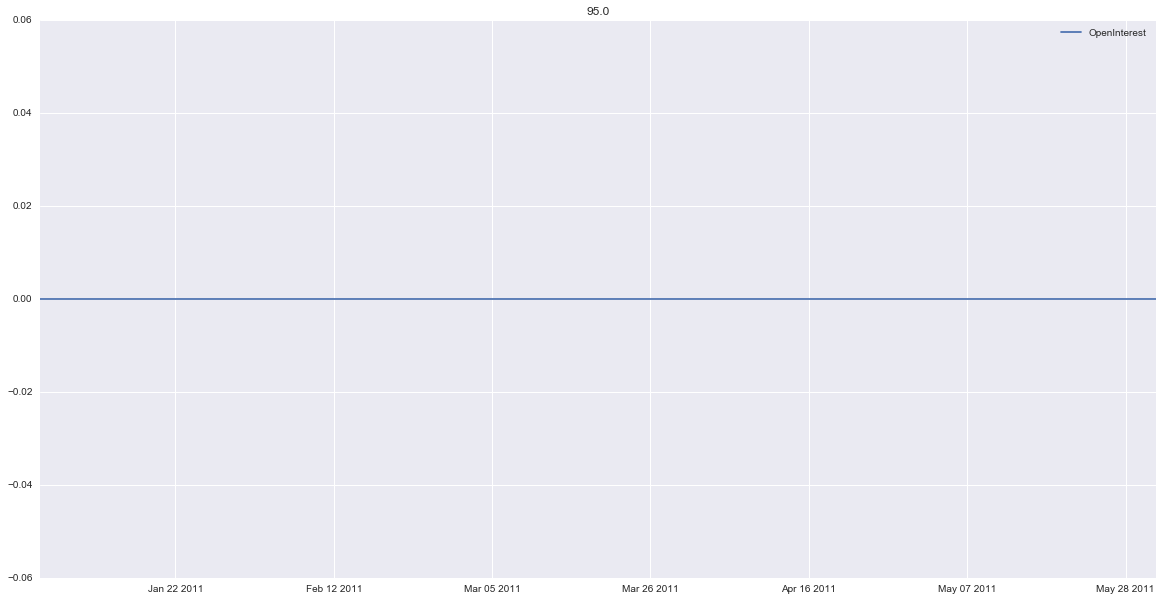

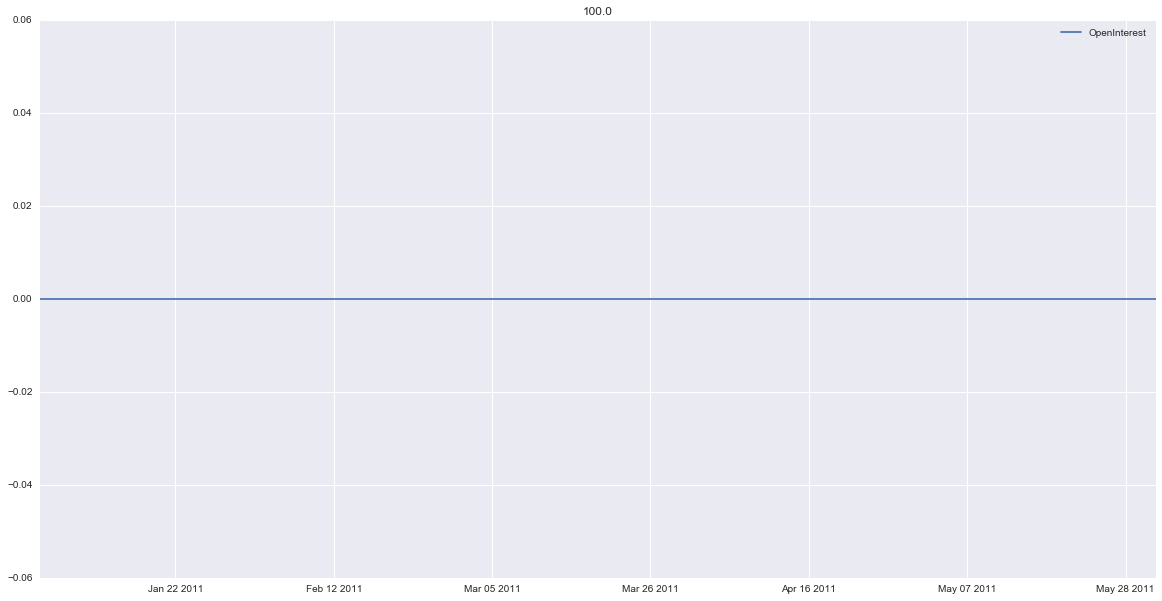

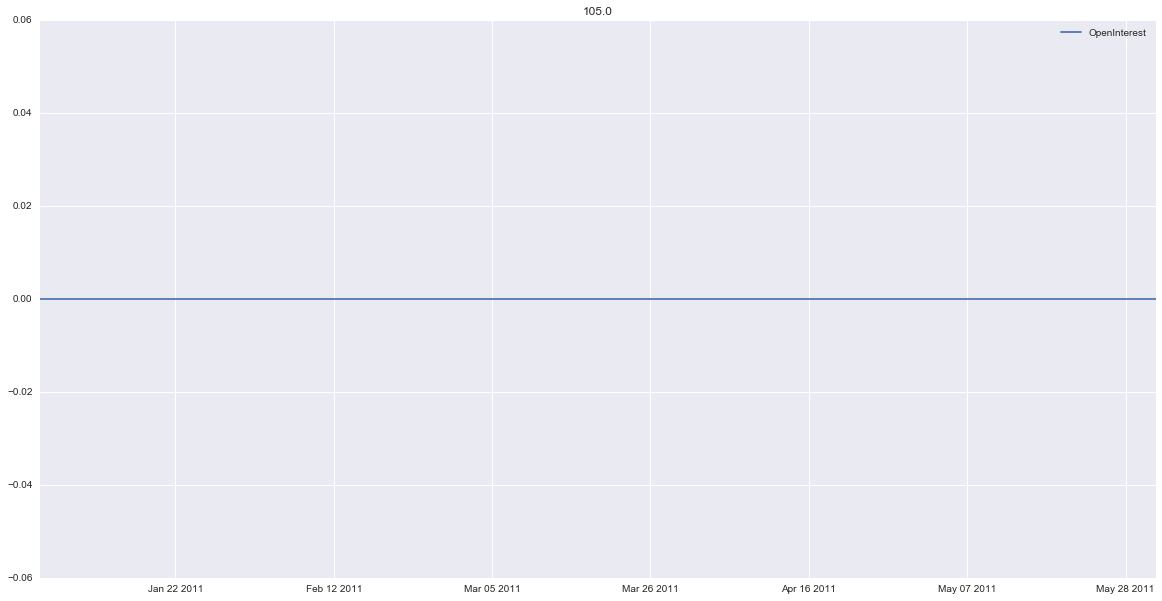

In [444]:
# Open Interest by strike, puts
for idx, row in ceph_data_p.groupby('Strike'):
    t_ = row.groupby('Date').sum()['OpenInterest']
    plt.figure()
    #plt.plot(row['Date'],row['OpenInterest'])
    plt.plot(t_)
    plt.title(idx)
    plt.gcf().set_size_inches(20, 10)
    plt.legend()
    plt.show()